### Library staff

Import libraries

In [80]:
import pandas as pd
import numpy as np
import os
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
import seaborn as sns
import warnings
import time
import datetime
from sklearn.metrics import r2_score, root_mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import pennylane as qml
from pennylane.transforms import decompose
from collections import defaultdict
from IPython.display import clear_output
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Dataset

## Loading

Define Variables

In [2]:
DATASET_PATH = f"cesnet-time-series-2023-2024/"

SAMPLE_IP_ADDRESSES = f"ip_addresses_sample/"
FULL_IP_ADDRESSES = f"ip_addresses_full/"
INSTITUTIONS = f"institutions/"
INSTITUTION_SUBNETS = f"institution_subnets/"

AGGREAGATIONS = [
    "agg_10_minutes/",
    "agg_1_hour/", 
    "agg_1_day/"
]

TIMES = [
    f"{DATASET_PATH}/times/times_10_minutes.csv", 
    f"{DATASET_PATH}/times/times_1_hour.csv", 
    f"{DATASET_PATH}/times/times_1_day.csv"
]

Create function for fill missing values in time series

In [3]:
# ПЕРЕПИСАТЬ С ИНТЕРПОЛЯЦИЕЙ
def fill_missing(train_df, train_time_ids):
    df_missing = pd.DataFrame(columns=train_df.columns)
    df_missing.id_time = train_time_ids[~train_time_ids.isin(train_df.id_time)].values
    
    for column in train_df.columns:
        if column == "id_time":
            continue
        if column in ["tcp_udp_ratio_packets","tcp_udp_ratio_bytes","dir_ratio_packets","dir_ratio_bytes"]:
            df_missing[column] = 0.5
            # print(0.5)
        else:
            df_missing[column] = 0 # train_df[column].mean()
            # print(0)
    
    return pd.concat([train_df, df_missing]).sort_values(by="id_time").reset_index()[train_df.columns]

## Show time series 

For aggregation set to 1 hour

In [4]:
index = 1

FILE = "1/103.csv"

Load Times file

In [5]:
df_times = pd.read_csv(TIMES[index])
df_times['time'] = pd.to_datetime(df_times['time'])
df_times

id_time                      time
0           0 2023-10-09 00:00:00+00:00
1           1 2023-10-09 01:00:00+00:00
2           2 2023-10-09 02:00:00+00:00
3           3 2023-10-09 03:00:00+00:00
4           4 2023-10-09 04:00:00+00:00
...       ...                       ...
6713     6713 2024-07-14 17:00:00+00:00
6714     6714 2024-07-14 18:00:00+00:00
6715     6715 2024-07-14 19:00:00+00:00
6716     6716 2024-07-14 20:00:00+00:00
6717     6717 2024-07-14 21:00:00+00:00

[6718 rows x 2 columns]

Load time series file from Full IP addresses dataset part

In [6]:
path = f"{DATASET_PATH}{FULL_IP_ADDRESSES}{AGGREAGATIONS[index]}{FILE}"
df = pd.read_csv(f"{path}")
df

id_time  n_flows  n_packets     n_bytes  sum_n_dest_asn  \
0           0     3901     393434   206437830             422   
1           1     5423     480314   416708062             474   
2           2    10196    1651033  1648205236             644   
3           3    37372    3648527  3468605008            1152   
4           4    67321    8376092  7831268053            1573   
...       ...      ...        ...         ...             ...   
6712     6713     3117     667446   703476155             331   
6713     6714     2687     865314   951109976             245   
6714     6715     2942    1003893  1007064376             292   
6715     6716     2519     826996   882041132             248   
6716     6717     1995     306979   299032633             249   

      average_n_dest_asn  std_n_dest_asn  sum_n_dest_ports  \
0                  70.33            5.47               215   
1                  79.00            9.84               258   
2                 107.33           15.07               280   
3                 192.00           42.70               557   
4                 262.17            8.01               618   
...                  ...             ...               ...   
6712               55.17            7.31               169   
6713               40.83            2.40               134   
6714               48.67            7.00               158   
6715               41.33            5.20               128   
6716               41.50            7.01               123   

      average_n_dest_ports  std_n_dest_ports  sum_n_dest_ip  \
0                    35.83              5.04           1885   
1                    43.00              3.58           2400   
2                    46.67              7.00           4495   
3                    92.83             27.88          11353   
4                   103.00              8.32          17531   
...                    ...               ...            ...   
6712                 28.17              3.06           1631   
6713                 22.33              2.07           1329   
6714                 26.33              3.14           1459   
6715                 21.33              3.20           1198   
6716                 20.50              2.43           1081   

      average_n_dest_ip  std_n_dest_ip  tcp_udp_ratio_packets  \
0                314.17          28.76                   0.82   
1                400.00          45.36                   0.90   
2                749.17         190.41                   0.64   
3               1892.17         617.03                   0.75   
4               2921.83         127.13                   0.77   
...                 ...            ...                    ...   
6712             271.83          46.18                   0.50   
6713             221.50          10.39                   0.52   
6714             243.17          35.19                   0.45   
6715             199.67          24.93                   0.43   
6716             180.17          38.53                   0.73   

      tcp_udp_ratio_bytes  dir_ratio_packets  dir_ratio_bytes  avg_duration  \
0                    0.72               0.43             0.23         21.68   
1                    0.91               0.42             0.25         19.80   
2                    0.58               0.28             0.06         20.04   
3                    0.74               0.28             0.09         19.78   
4                    0.74               0.30             0.10         25.12   
...                   ...                ...              ...           ...   
6712                 0.51               0.20             0.04         29.22   
6713                 0.57               0.27             0.12         27.14   
6714                 0.43               0.32             0.22         28.92   
6715                 0.45               0.32             0.19         24.23   
6716                 0.75               0.32             0.13         29.

Fill missing values in loaded time series and add time column

In [7]:
df = fill_missing(df, df_times.id_time)
df['time'] = df_times['time']
df = df[['time'] + df.keys().drop('time').to_list()]
df

time  id_time  n_flows  n_packets     n_bytes  \
0    2023-10-09 00:00:00+00:00        0     3901     393434   206437830   
1    2023-10-09 01:00:00+00:00        1     5423     480314   416708062   
2    2023-10-09 02:00:00+00:00        2    10196    1651033  1648205236   
3    2023-10-09 03:00:00+00:00        3    37372    3648527  3468605008   
4    2023-10-09 04:00:00+00:00        4    67321    8376092  7831268053   
...                        ...      ...      ...        ...         ...   
6713 2024-07-14 17:00:00+00:00     6713     3117     667446   703476155   
6714 2024-07-14 18:00:00+00:00     6714     2687     865314   951109976   
6715 2024-07-14 19:00:00+00:00     6715     2942    1003893  1007064376   
6716 2024-07-14 20:00:00+00:00     6716     2519     826996   882041132   
6717 2024-07-14 21:00:00+00:00     6717     1995     306979   299032633   

      sum_n_dest_asn  average_n_dest_asn  std_n_dest_asn  sum_n_dest_ports  \
0                422               70.33            5.47               215   
1                474               79.00            9.84               258   
2                644              107.33           15.07               280   
3               1152              192.00           42.70               557   
4               1573              262.17            8.01               618   
...              ...                 ...             ...               ...   
6713             331               55.17            7.31               169   
6714             245               40.83            2.40               134   
6715             292               48.67            7.00               158   
6716             248               41.33            5.20               128   
6717             249               41.50            7.01               123   

      average_n_dest_ports  std_n_dest_ports  sum_n_dest_ip  \
0                    35.83              5.04           1885   
1                    43.00              3.58           2400   
2                    46.67              7.00           4495   
3                    92.83             27.88          11353   
4                   103.00              8.32          17531   
...                    ...               ...            ...   
6713                 28.17              3.06           1631   
6714                 22.33              2.07           1329   
6715                 26.33              3.14           1459   
6716                 21.33              3.20           1198   
6717                 20.50              2.43           1081   

      average_n_dest_ip  std_n_dest_ip  tcp_udp_ratio_packets  \
0                314.17          28.76                   0.82   
1                400.00          45.36                   0.90   
2                749.17         190.41                   0.64   
3               1892.17         617.03                   0.75   
4               2921.83         127.13                   0.77   
...                 ...            ...                    ...   
6713             271.83          46.18                   0.50   
6714             221.50          10.39                   0.52   
6715             243.17          35.19                   0.45   
6716             199.67          24.93                   0.43   
6717             180.17          38.53                   0.73   

      tcp_udp_ratio_bytes  dir_ratio_packets  dir_ratio_bytes  avg_duration  \
0                    0.72               0.43             0.23         21.68   
1                    0.91               0.42             0.25         19.80   
2                    0.58               0.28             0.06         20.04   
3                    0.74               0.28             0.09         19.78   
4                    0.74               0.30             0.10         25.12   
...                   ...                ...              ...           ...   
6713                 0.51               0.20             0.04         29.22   
6714              

## Dataset description

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6718 entries, 0 to 6717
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   time                   6718 non-null   datetime64[ns, UTC]
 1   id_time                6718 non-null   int64              
 2   n_flows                6718 non-null   int64              
 3   n_packets              6718 non-null   int64              
 4   n_bytes                6718 non-null   int64              
 5   sum_n_dest_asn         6718 non-null   int64              
 6   average_n_dest_asn     6718 non-null   float64            
 7   std_n_dest_asn         6718 non-null   float64            
 8   sum_n_dest_ports       6718 non-null   int64              
 9   average_n_dest_ports   6718 non-null   float64            
 10  std_n_dest_ports       6718 non-null   float64            
 11  sum_n_dest_ip          6718 non-null   int64            

In [9]:
df.describe()

id_time        n_flows     n_packets       n_bytes  sum_n_dest_asn  \
count  6718.000000    6718.000000  6.718000e+03  6.718000e+03     6718.000000   
mean   3358.500000   21358.236231  2.973588e+06  2.887134e+09     1263.552545   
std    1939.463886   24879.214597  2.986046e+06  2.906549e+09      930.400831   
min       0.000000       0.000000  0.000000e+00  0.000000e+00        0.000000   
25%    1679.250000    5198.750000  9.131748e+05  8.864145e+08      569.250000   
50%    3358.500000   11943.000000  2.035128e+06  1.985877e+09      972.500000   
75%    5037.750000   25610.750000  3.760321e+06  3.650603e+09     1712.000000   
max    6717.000000  137970.000000  2.059247e+07  2.308840e+10     7062.000000   

       average_n_dest_asn  std_n_dest_asn  sum_n_dest_ports  \
count         6718.000000     6718.000000       6718.000000   
mean           210.615976       27.573251       1214.708842   
std            155.102387       33.743849       1631.427947   
min              0.000000        0.000000          0.000000   
25%             95.000000        9.632500        330.000000   
50%            162.085000       17.030000        645.000000   
75%            285.330000       33.160000       1531.750000   
max           1177.000000      720.370000      28302.000000   

       average_n_dest_ports  std_n_dest_ports  sum_n_dest_ip  \
count           6718.000000       6718.000000    6718.000000   
mean             202.484455         65.197047    7417.569961   
std              271.991500        189.740926    6359.184228   
min                0.000000          0.000000       0.000000   
25%               55.000000          8.365000    2694.250000   
50%              107.500000         19.920000    5424.500000   
75%              255.290000         53.877500    9841.000000   
max             4717.000000       5034.040000   35575.000000   

       average_n_dest_ip  std_n_dest_ip  tcp_udp_ratio_packets  \
count        6718.000000    6718.000000            6718.000000   
mean         1236.372897     112.662754               0.742776   
std          1059.958748     139.365590               0.100725   
min             0.000000       0.000000               0.240000   
25%           449.042500      42.890000               0.690000   
50%           904.080000      76.055000               0.750000   
75%          1640.165000     136.760000               0.810000   
max          5929.170000    3407.130000               0.990000   

       tcp_udp_ratio_bytes  dir_ratio_packets  dir_ratio_bytes  avg_duration  \
count          6718.000000        6718.000000      6718.000000   6718.000000   
mean              0.745183           0.316468         0.118647     24.950353   
std               0.110030           0.073669         0.073246      4.273635   
min               0.240000           0.040000         0.000000      0.000000   
25%               0.680000           0.280000         0.070000     22.280000   
50%               0.750000           0.310000         0.100000     25.380000   
75%               0.820000           0.350000         0.150000     27.847500   
max               1.000000           0.690000         0.660000     61.410000   

           avg_ttl  
count  6718.000000  
mean     83.096615  
std       4.851083  
min       0.000000  
25%      79.922500  
50%      83.120000  
75%      86.140000  
max     118.250000

### Plot time series's features 

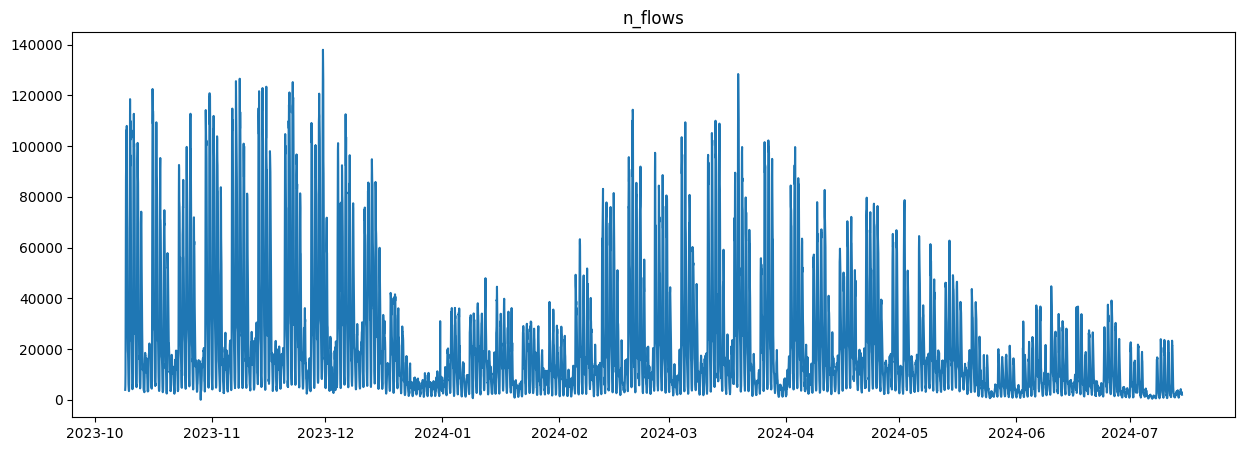

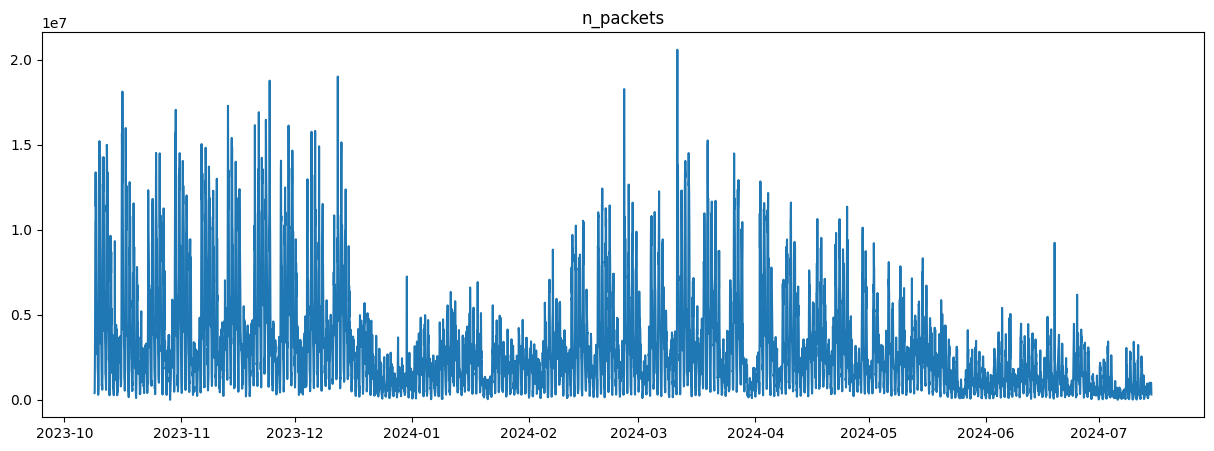

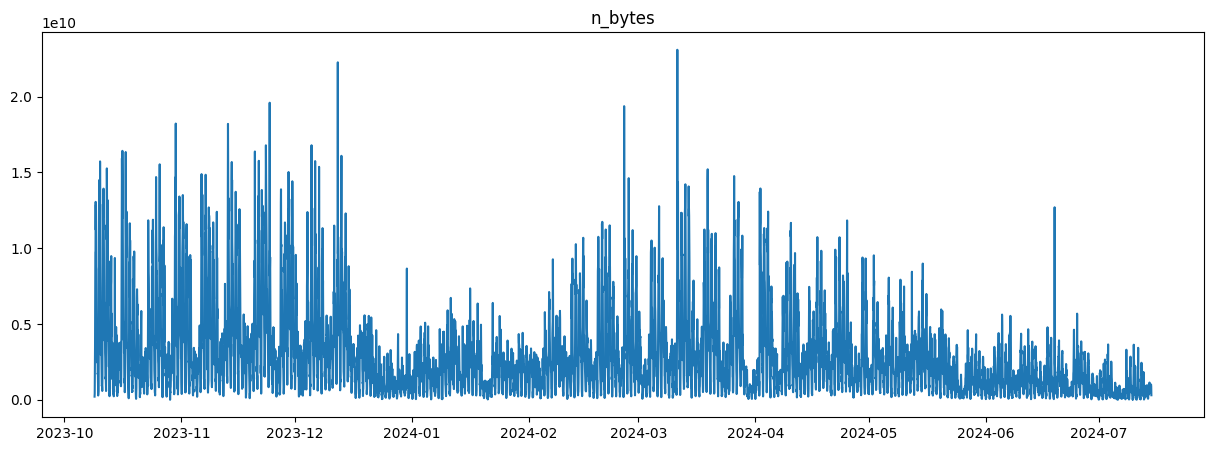

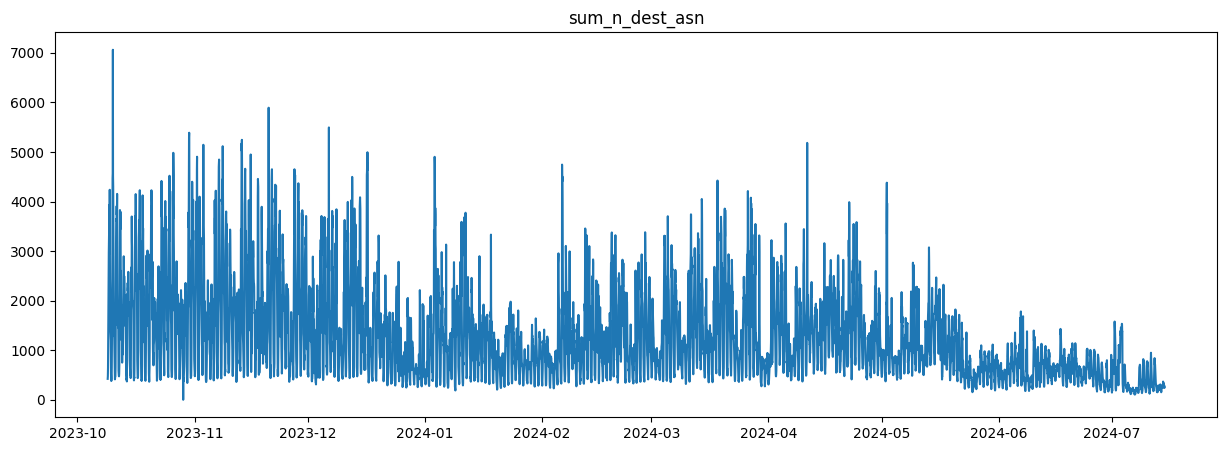

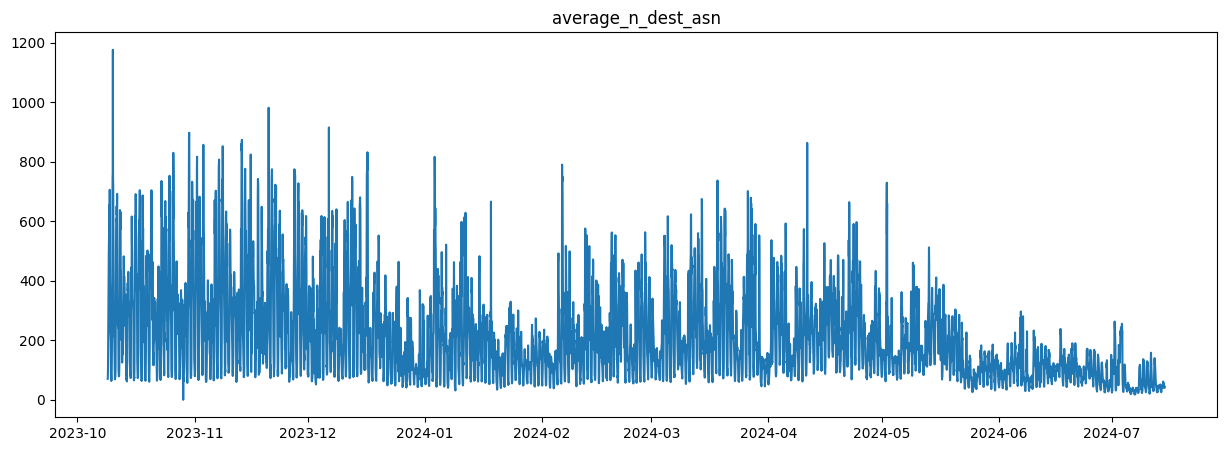

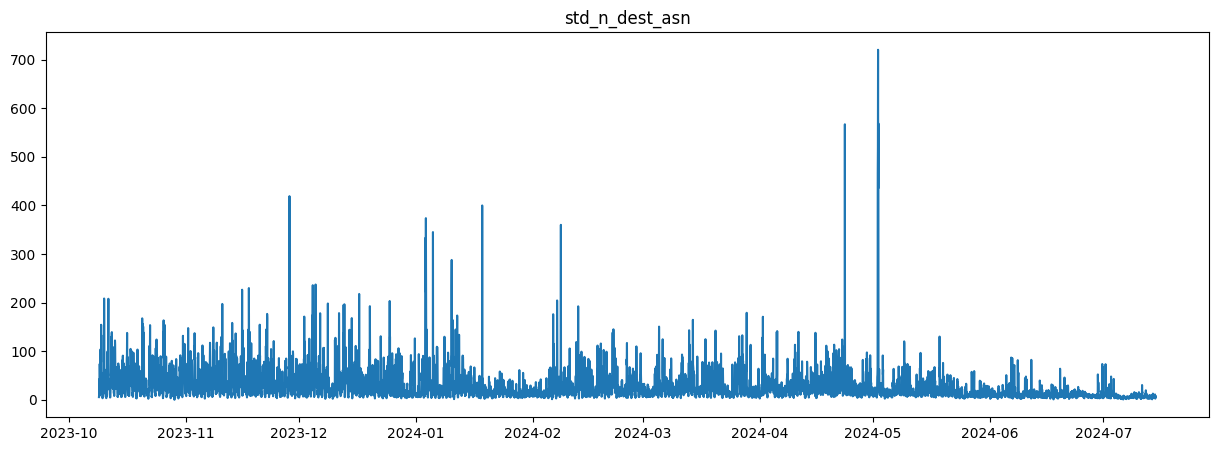

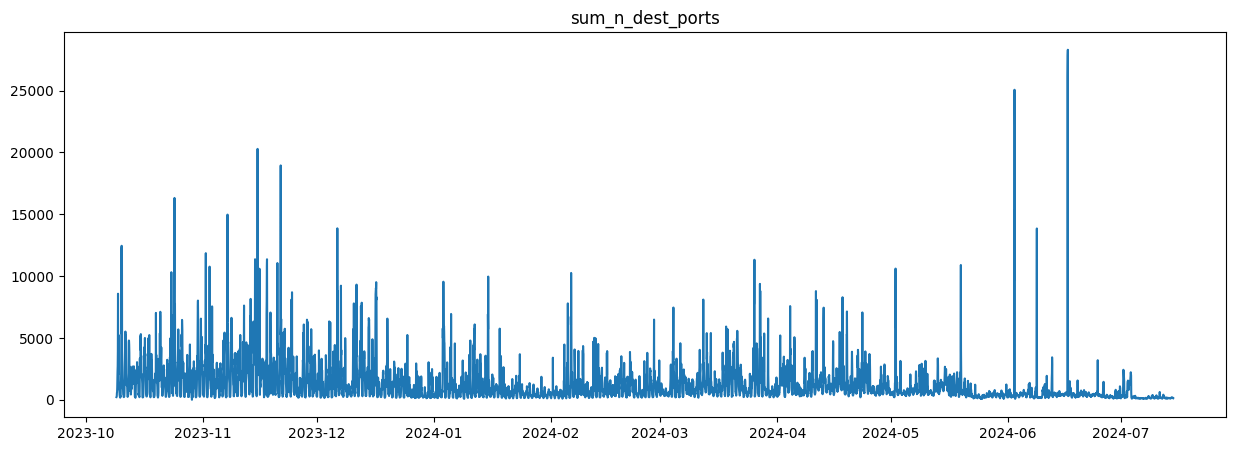

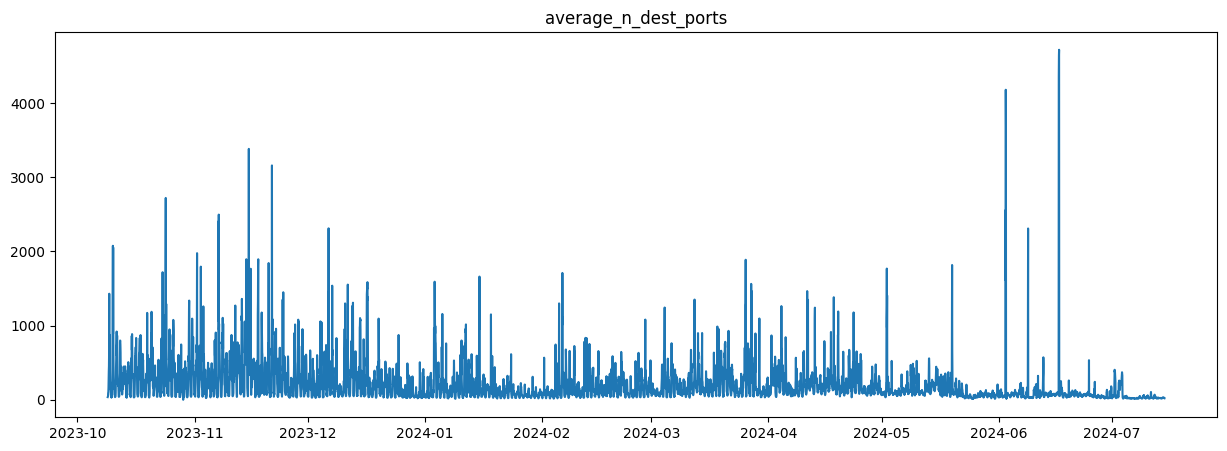

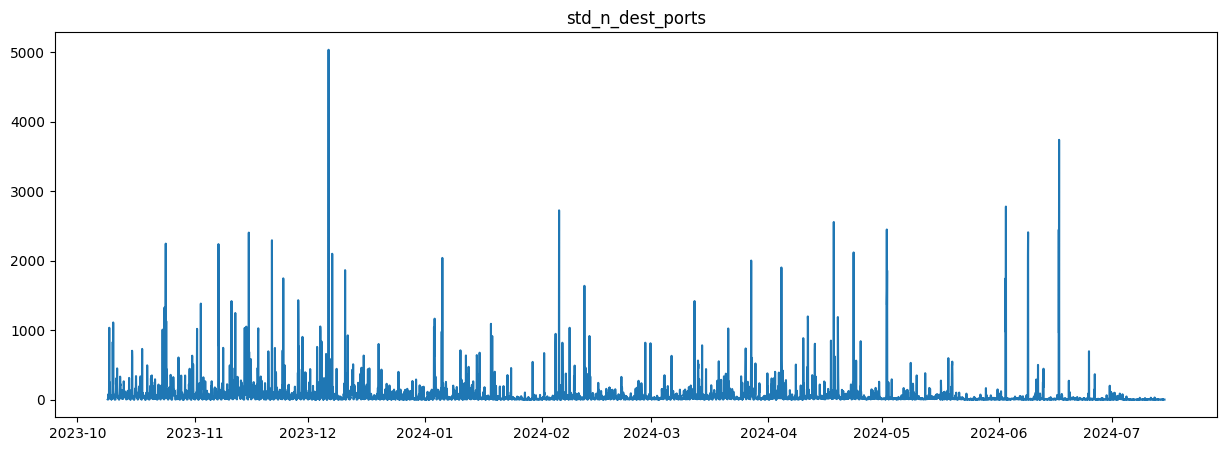

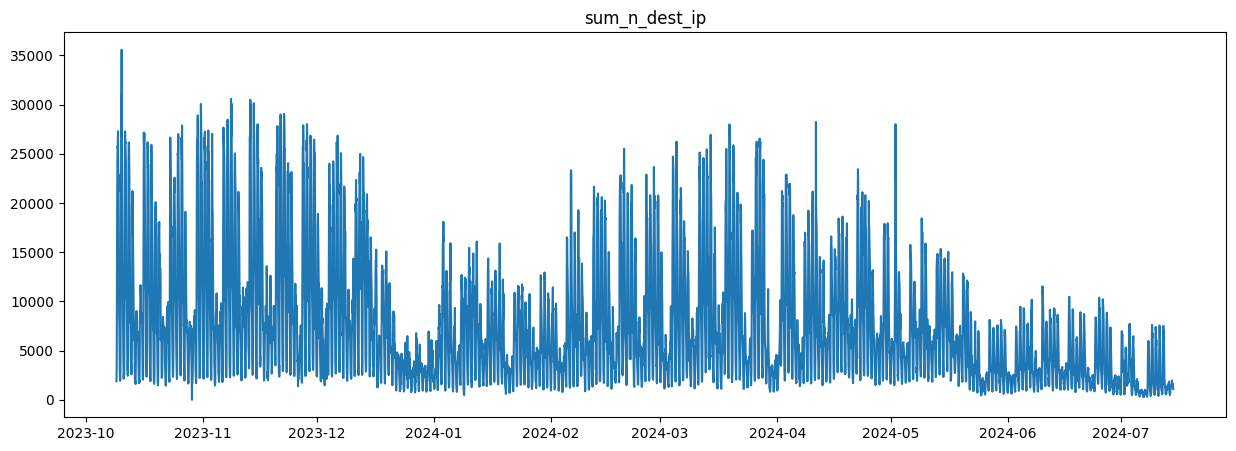

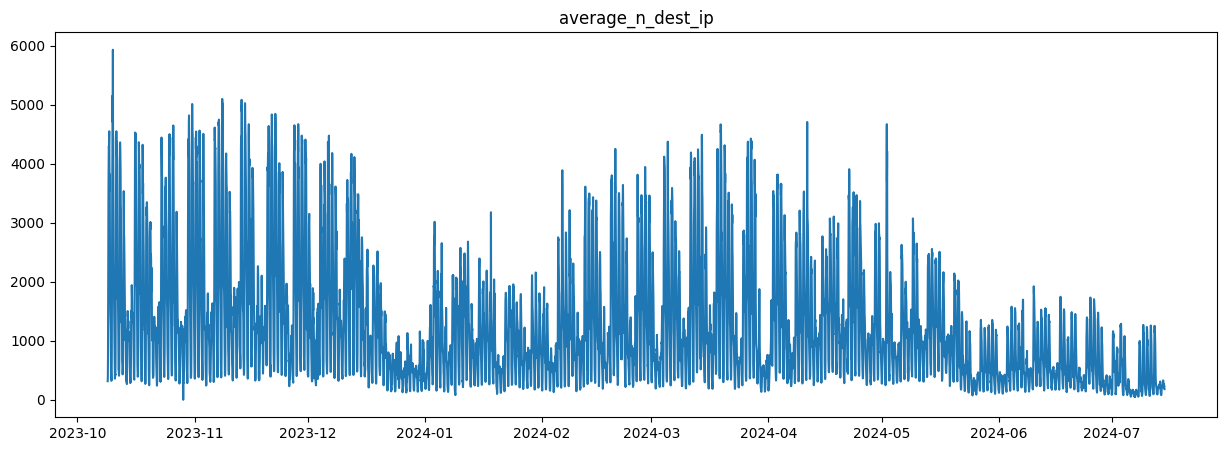

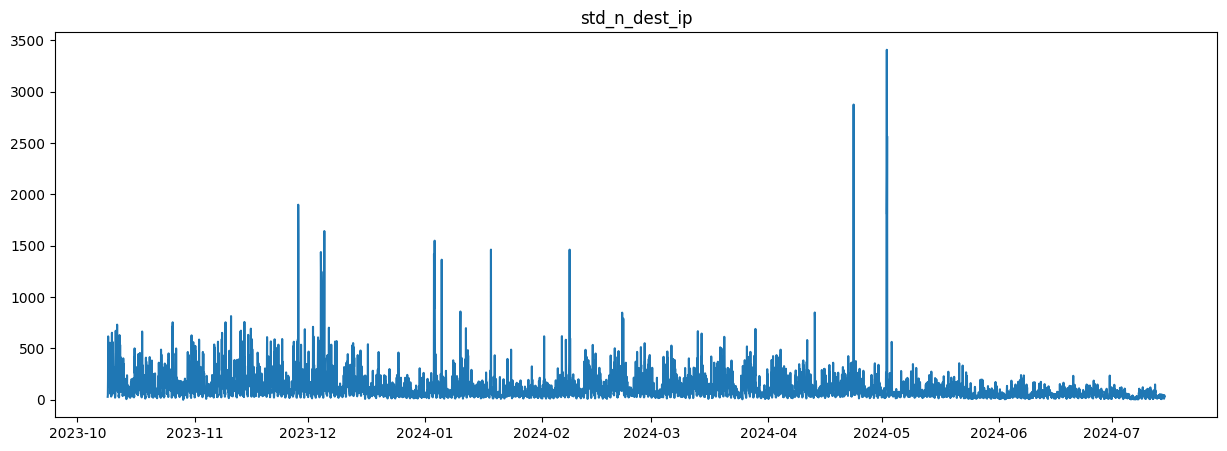

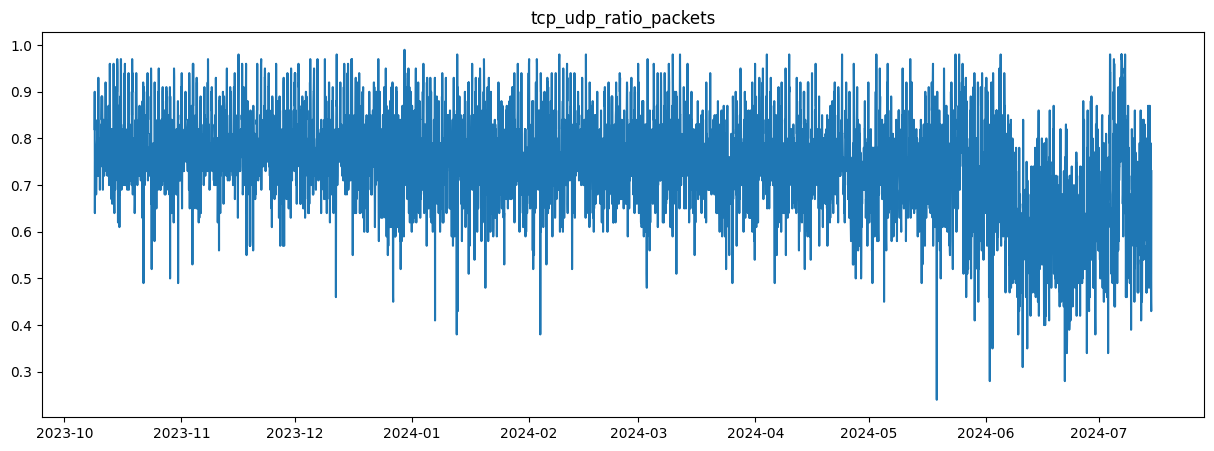

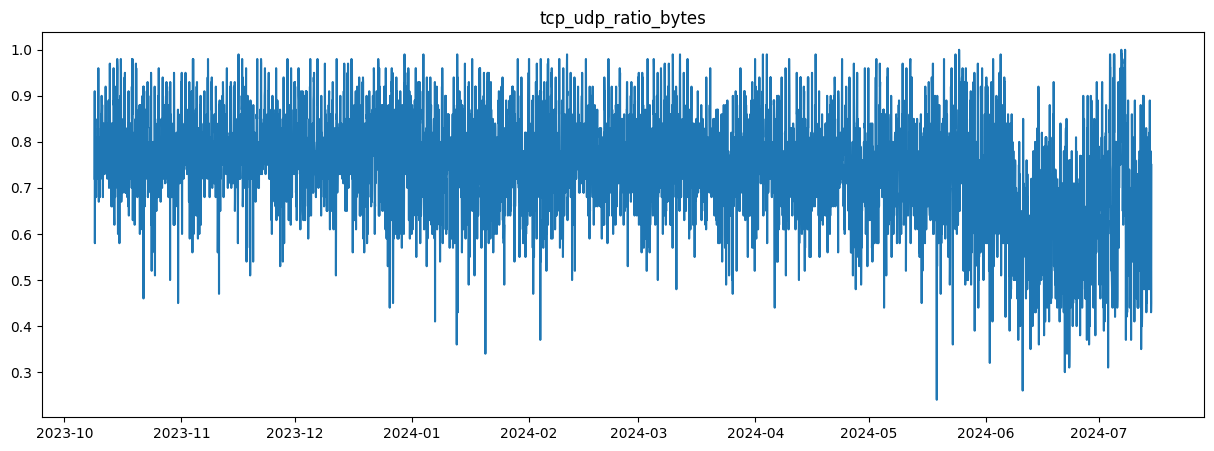

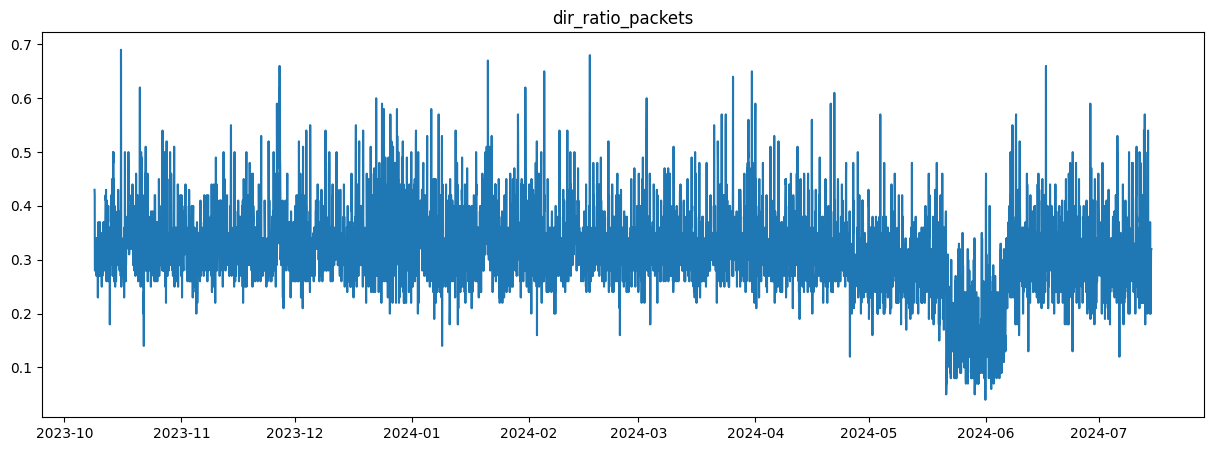

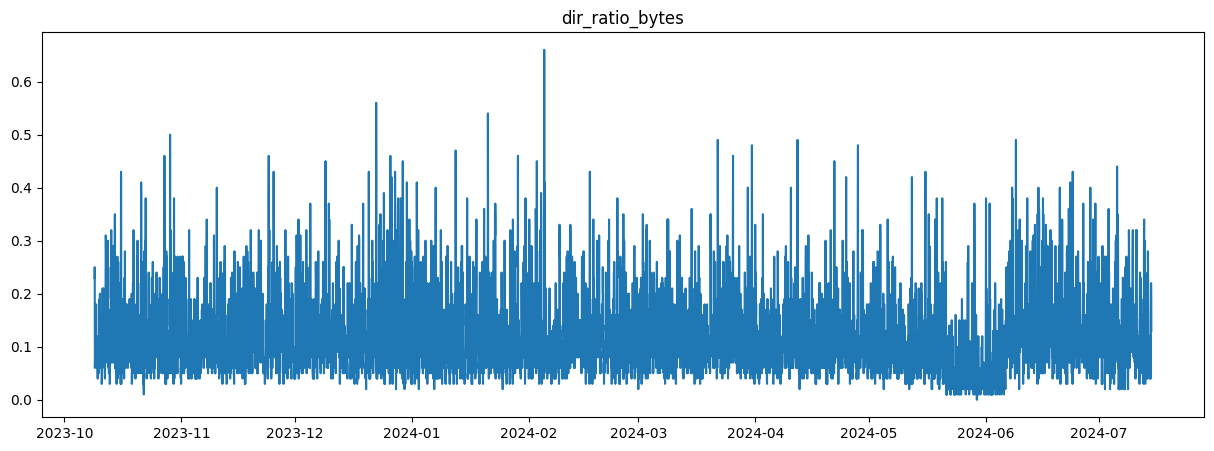

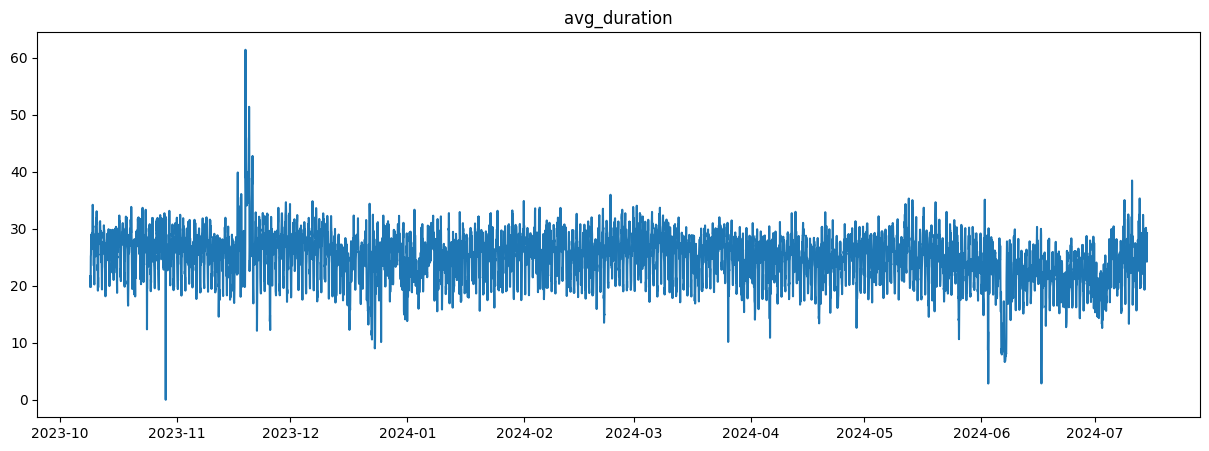

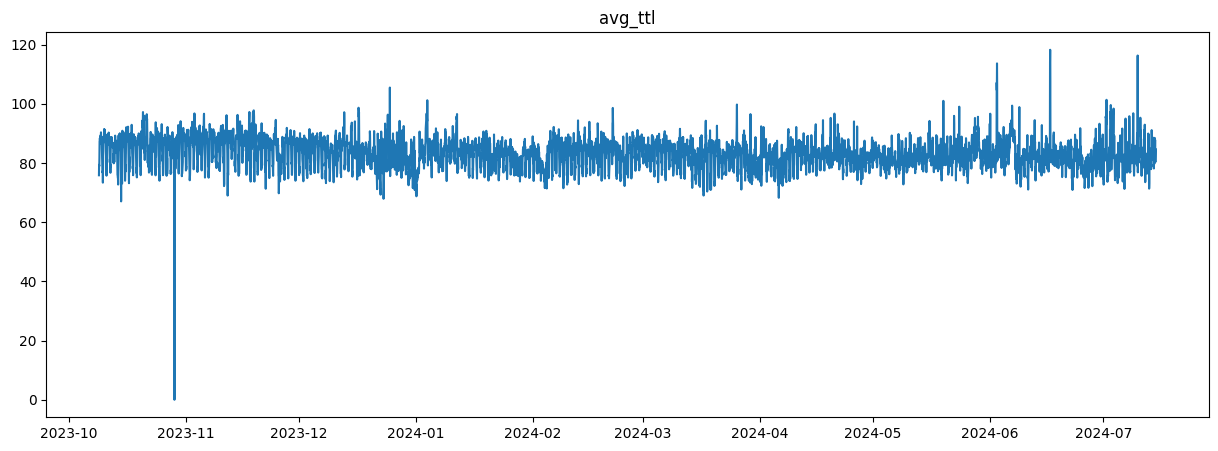

In [10]:
for feature in df.keys():
    if feature == 'time' or feature == 'id_time':
        continue
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(df.time, df[feature])
    plt.title(feature)
    plt.show()
    plt.close()

<Axes: >

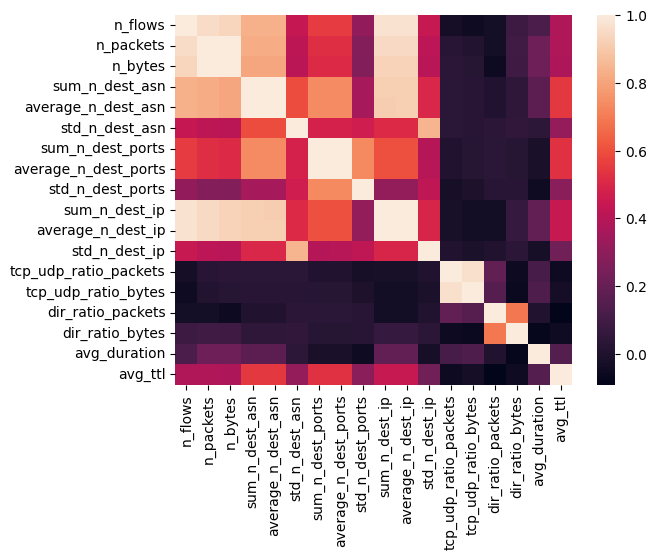

In [11]:
sns.heatmap(df[df.keys().drop('id_time').to_list()].corr(numeric_only=True)) # , annot=True

## Feature to forecast

In [12]:
TS_FEAT = 'n_flows'

In [13]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 168

In [14]:
offset = 6 * 168
train_df = df[(df.id_time >= offset) & (df.id_time < offset + TRAINING_PERIOD)]
train_data = train_df[TS_FEAT].to_numpy()

test_df = df.loc[(df.id_time >= offset + TRAINING_PERIOD) & (df.id_time < offset + TRAINING_PERIOD + TESTING_PERIOD)]

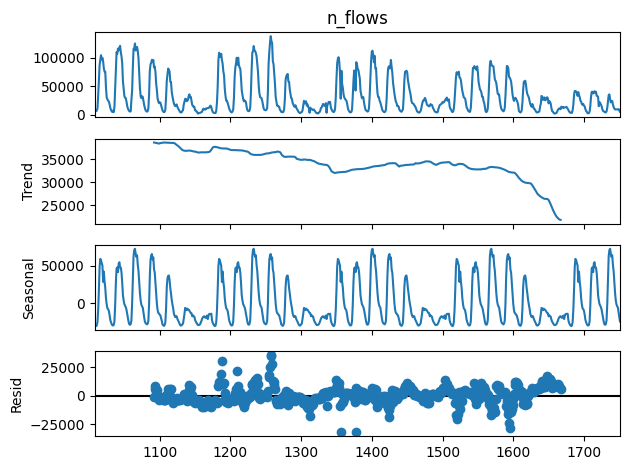

In [15]:
seasonal_decompose(train_df[TS_FEAT], model="additive", period=168).plot()
plt.show()

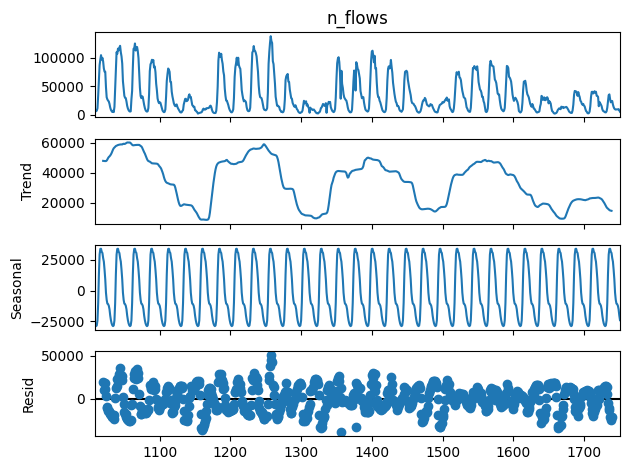

In [16]:
seasonal_decompose(train_df[TS_FEAT], model="additive", period=24).plot()
plt.show()

Check if series is stationary

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(train_df[TS_FEAT]))

Results of Dickey-Fuller Test:
Test Statistic                  -1.753449
p-value                          0.403805
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64
None


So the data has trend, so we need first-order differencing

# Functions

**Metrics description**

Evaluation metrics are critical in assessing the performance of regression models. Below are some commonly used metrics in regression analysis.

**RMSE**

**Root Mean Squared Error (RMSE)** is a measure of the differences between predicted and actual values. It gives an idea of how far the residuals (the differences between actual and predicted values) are from zero. The RMSE is especially useful when large errors are particularly undesirable.

The RMSE is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

**SMAPE**

**Symmetric Mean Absolute Percentage Error (SMAPE)** is an accuracy measure based on percentage errors. It is useful when you want to express errors as a percentage, and it is symmetric, meaning it treats overestimations and underestimations equally.

The SMAPE is defined as:

$$
\text{SMAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

**R2 score**

**R-squared ($ R^2 $)** is a statistical measure that indicates how well the regression predictions approximate the actual data points. It provides the proportion of the variance in the dependent variable that is predictable from the independent variables.

The $ R^2 $ score is defined as:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value
- $ \bar{y} $ is the mean of the actual values

The $ R^2 $ value ranges from 0 to 1, with 1 indicating that the model perfectly predicts the data and 0 indicating that the model does not explain any of the variance in the data.

In [18]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

In [19]:
def calc_metrics(test_df, pred_data, feature_name=TS_FEAT):
    results_rmse = root_mean_squared_error(test_df[feature_name], pred_data[:len(test_df[feature_name])])
    results_smape = smape(test_df[feature_name], pred_data[:len(test_df[feature_name])])
    results_r2_score = r2_score(test_df[feature_name], pred_data[:len(test_df[feature_name])])
    return results_rmse, results_smape, results_r2_score

In [20]:
def plot_forecast(train_df, test_df, pred_df, feature_name=TS_FEAT):
    fig, ax = plt.subplots(figsize=(15,5))
    matplotlib.rcParams.update({'font.size': 12})
    ax.plot(train_df.time, train_df[feature_name], color='blue', label='train data')
    ax.plot(test_df.time, test_df[feature_name], color='green', label='test data')
    ax.plot(pred_df.time, pred_df[feature_name], color='orange', label='predictions')
    plt.legend(loc=2)
    plt.xlabel("Time")
    plt.ylabel(feature_name)
    plt.tight_layout()
    plt.show()

In [21]:
def save_logs(file_path, train_df, test_df, pred_df, feature_name=TS_FEAT):
    train_data = pd.concat([train_df.time, train_df[feature_name]], axis=1)
    train_data.to_csv(file_path, sep='\t')
    
    test_data = pd.concat([test_df.time, test_df[feature_name]], axis=1)
    test_data.to_csv(file_path, sep='\t')
    
    pred_data = pd.concat([pred_df.time, pred_df[feature_name]], axis=1)
    pred_data.to_csv(file_path, sep='\t')

In [22]:
def recover_plot_from_file(file_path, feature_name=TS_FEAT):
    train_df = pd.read_csv(file_path, sep='\t', index_col=0)
    test_df = pd.read_csv(file_path, sep='\t', index_col=0)
    pred_df = pd.read_csv(file_path, sep='\t', index_col=0)
    plot_forecast(train_df, test_df, pred_df)

In [23]:
def sliding_windows(data, w_size, step=1): 
    # подаем окно [x_n, ..., x_{n+w_size}], предсказываем x_{n+w_size+step}
    x = []
    y = []

    for i in range(len(data) - w_size):
        _x = data[i : (i + w_size)]
        _y = data[i + w_size + step - 1]
        x.append(_x)
        y.append(_y)
    
    return np.array(x), np.array(y)

In [24]:
class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="best")
        if history_len < 20:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(24 // n_groups, 5))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

# SARIMA

## Hyperparameters tuning

In [31]:
dataset = train_df[['time', TS_FEAT]]
dataset = dataset.rename(columns={'time': 'ds', TS_FEAT: 'y'}) # rename columns to match StatsForecast format
dataset["unique_id"] = "?"  # add "unique_id" column (required for StatsForecast)

In [234]:
%%time
sf = StatsForecast(models=[AutoARIMA(season_length=168)], freq="H", n_jobs=-1)
sf.fit(dataset)

CPU times: total: 6min 38s
Wall time: 6min 39s


StatsForecast(models=[AutoARIMA])

In [235]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(0,1,1)(0,1,0)[168]                   '

## Functions

In [25]:
# original
# ORDER = (1, 1, 1)
# SEASONAL_ORDER = (1, 1, 1, 168)

# no offset in training data
ORDER = (3, 1, 2)
SEASONAL_ORDER = (0, 1, 0, 168)

# with offset
# ORDER = (0, 1, 1)
# SEASONAL_ORDER = (0, 1, 0, 168)

In [26]:
# Also sliding windows?
class SARIMA_TRAINING:
    def __init__(self, train_period, df=df, feature_name=TS_FEAT, offset=0, order=ORDER, seasonal_order=SEASONAL_ORDER):
        self.train_period = train_period
        self.test_period = None
        
        self.df = df
        self.feature_name = feature_name
        self.order = order
        self.seasonal_order = seasonal_order
        
        self.train_df = self.df[(df.id_time >= offset) & (self.df.id_time < offset + self.train_period)]
        self.train_data = self.train_df[self.feature_name].to_numpy()
        self.test_df = None
        self.test_data = None
        
        self.model = None
        self.results = None
        self.train_time = None
        
        self.pred_df = None
        self.pred_data = None

        self.results_rmse = None
        self.results_r2_score = None
        self.results_smape = None
        
    def train(self):
        start_time = time.time()
        self.model = SARIMAX(self.train_data, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=False)
        final_time = time.time()
        self.train_time = str(datetime.timedelta(seconds=np.ceil(final_time - start_time)))
    
    def predict(self, test_period):
        self.test_period = test_period
        self.test_df = self.df.loc[(self.df.id_time >= offset + self.train_period) & (self.df.id_time < offset + self.train_period + self.test_period)]
        self.test_data = self.test_df[self.feature_name].to_numpy()
        
        self.pred_data = list(self.results.forecast(steps=self.test_period))
        pred_df = pd.DataFrame(self.pred_data, index=self.test_df.index, columns=[self.feature_name])
        pred_df.time = self.test_df.time
        self.pred_df = pred_df        

    def plot_prediction(self):
        plot_forecast(self.train_df, self.test_df, self.pred_df)

    def scores(self):
        self.results_rmse, self.results_smape, self.results_r2_score = calc_metrics(self.test_df, self.pred_data)

    def save_plot_logs(self, file_path):
        save_logs(file_path, self.train_df, self.test_df, self.pred_df,)

## Multistep forecast

### 7 days

Train data - first month (744 hours) \
Test data - one week after the month (168 hours)

In [27]:
offset = 0
TRAINING_PERIOD = 744
TESTING_PERIOD = 168

model = SARIMA_TRAINING(TRAINING_PERIOD, offset=offset)
model.train()

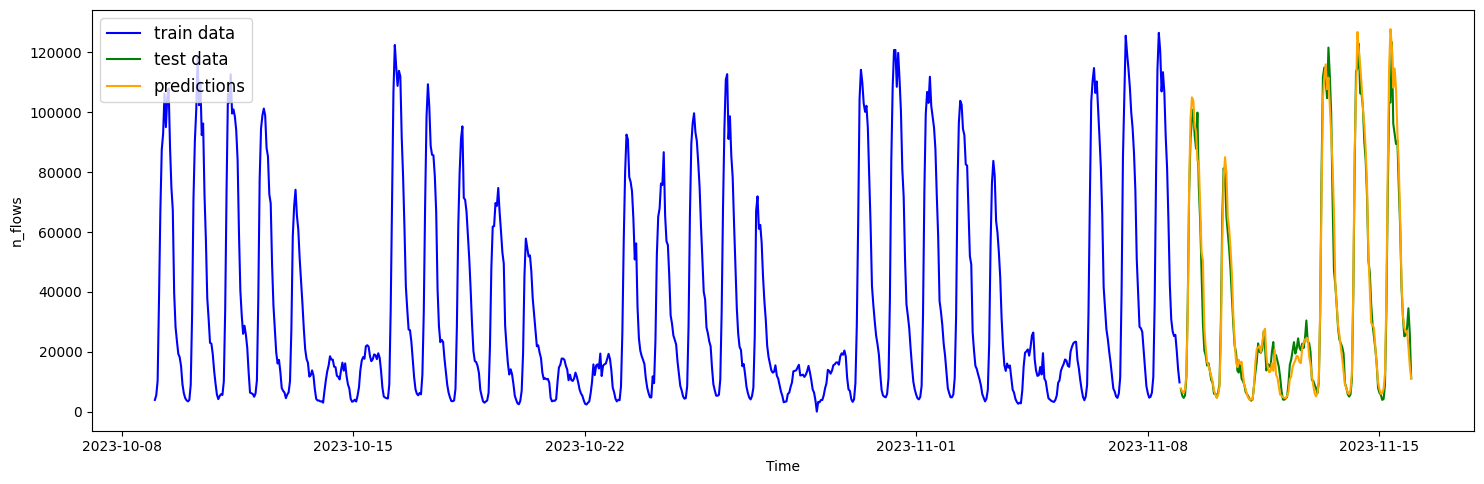

In [28]:
model.predict(TESTING_PERIOD)
model.plot_prediction()

In [29]:
metrics = pd.DataFrame(columns=['train / test size', 'Training time', 'RMSE', 'SMAPE', 'R2'])
metrics.style.set_caption("SARIMA multistep prediction")

In [30]:
model.scores()
metrics.loc[0] = ["744 h (31 d) / 168 h (7 d)", 
                  model.train_time, 
                  f'{model.results_rmse:.0f}', 
                  f'{model.results_smape:.2f}', 
                  f'{model.results_r2_score:.4f}']
metrics

train / test size Training time  RMSE  SMAPE      R2
0  744 h (31 d) / 168 h (7 d)       0:01:09  6043  14.67  0.9701

### 14 days

Train data - first month (744 hours) \
Test data - two weeks after the month (336 hours)

In [31]:
offset = 0
TRAINING_PERIOD = 744
TESTING_PERIOD = 336

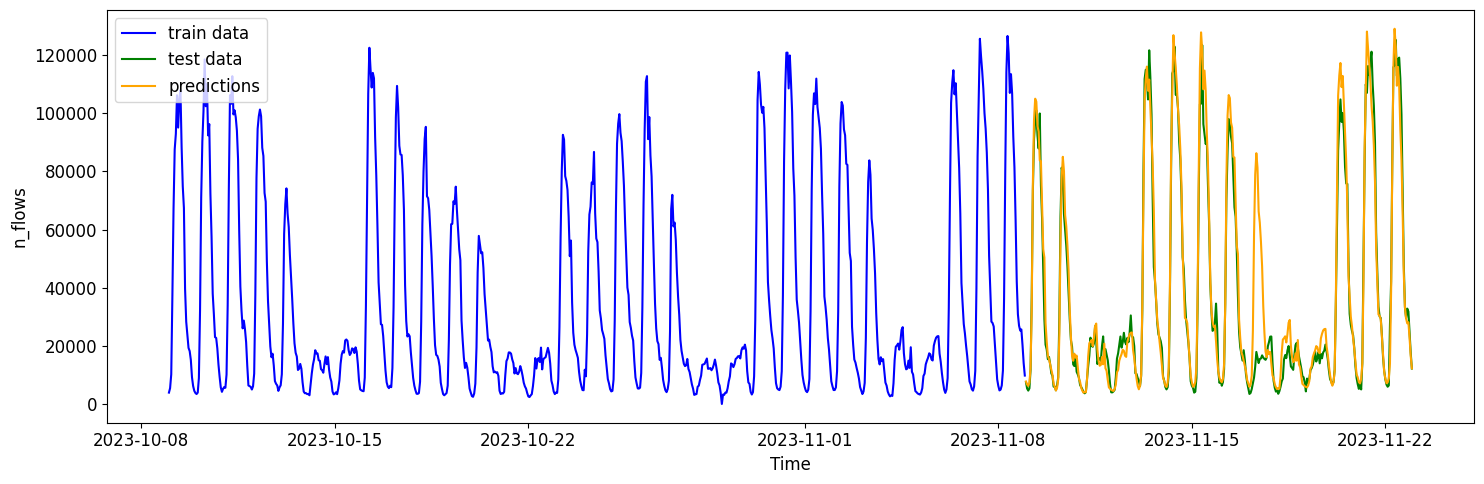

In [32]:
model.predict(TESTING_PERIOD)
model.plot_prediction()

In [33]:
model.scores()
metrics.loc[1] = ["744 h (31 d) / 336 h (14 d)", 
                  '-', 
                  f'{model.results_rmse:.0f}', 
                  f'{model.results_smape:.2f}', 
                  f'{model.results_r2_score:.4f}']
metrics

train / test size Training time   RMSE  SMAPE      R2
0   744 h (31 d) / 168 h (7 d)       0:01:09   6043  14.67  0.9701
1  744 h (31 d) / 336 h (14 d)             -  10462  19.05  0.9131

### 21 days

Train data - first month (744 hours) \
Test data - three weeks after the month (504 hours)

In [34]:
offset = 0
TRAINING_PERIOD = 744
TESTING_PERIOD = 504

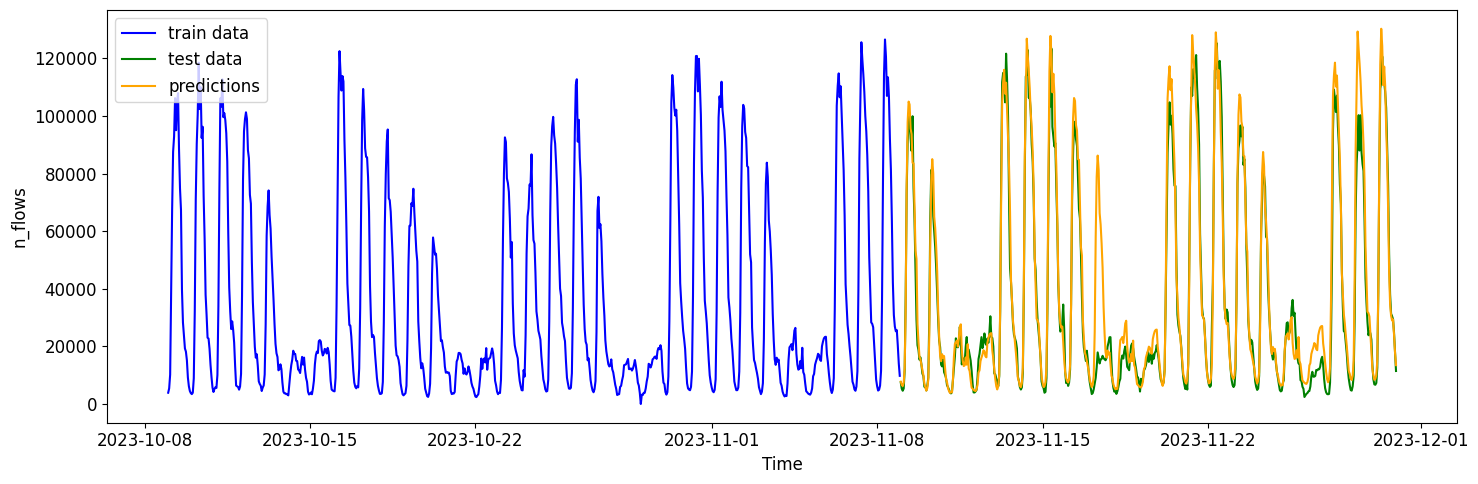

In [35]:
model.predict(TESTING_PERIOD)
model.plot_prediction()

In [36]:
model.scores()
metrics.loc[2] = ["744 h (31 d) / 504 h (21 d)", 
                  '-', 
                  f'{model.results_rmse:.0f}', 
                  f'{model.results_smape:.2f}', 
                  f'{model.results_r2_score:.4f}']
metrics

train / test size Training time   RMSE  SMAPE      R2
0   744 h (31 d) / 168 h (7 d)       0:01:09   6043  14.67  0.9701
1  744 h (31 d) / 336 h (14 d)             -  10462  19.05  0.9131
2  744 h (31 d) / 504 h (21 d)             -   9810  21.21  0.9217

### 60 days

Train data - first month (744 hours) \
Test data - 60 days after the month (1440 hours)

In [37]:
offset = 0
TRAINING_PERIOD = 744
TESTING_PERIOD = 1440

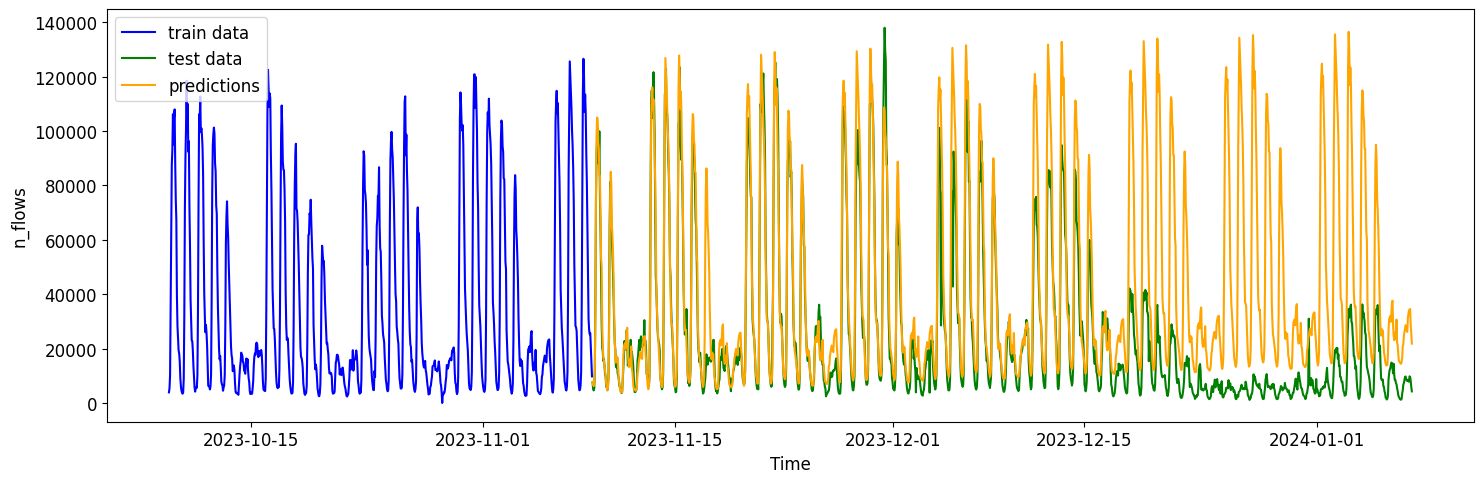

In [38]:
model.predict(TESTING_PERIOD)
model.plot_prediction()

In [39]:
model.scores()
metrics.loc[3] = ["744 h (31 d) / 1440 h (60 d)", 
                  '-', 
                  f'{model.results_rmse:.0f}', 
                  f'{model.results_smape:.2f}', 
                  f'{model.results_r2_score:.4f}']
metrics

train / test size Training time   RMSE  SMAPE       R2
0    744 h (31 d) / 168 h (7 d)       0:01:09   6043  14.67   0.9701
1   744 h (31 d) / 336 h (14 d)             -  10462  19.05   0.9131
2   744 h (31 d) / 504 h (21 d)             -   9810  21.21   0.9217
3  744 h (31 d) / 1440 h (60 d)             -  30107  62.21  -0.0739

## With retrain every 7 days

Forecasting time series feature 'n_flows' for the rest 249 days with retraining every 7 days

Train data - first month (744 hours) \
Test data - the rest data (168 hours)

In [292]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 168

In [44]:
train_df = df[df.id_time < TRAINING_PERIOD]
test_df = df.loc[(df.id_time >= TRAINING_PERIOD)]

In [47]:
%%time
tmp_index = 0
prediction = []
while tmp_index <= df.id_time.max() - TRAINING_PERIOD:
    train_df_tmp = df[df.id_time < tmp_index + TRAINING_PERIOD]
    train_df_tmp = train_df_tmp[train_df_tmp.id_time >= tmp_index]
    train_data_tmp = train_df_tmp[TS_FEAT].to_numpy()
        
    model = SARIMAX(train_data_tmp, order=ORDER, seasonal_order=SEASONAL_ORDER)
    results = model.fit(disp=False)
        
    prediction += list(results.forecast(steps=TESTING_PERIOD))
    tmp_index += TESTING_PERIOD

CPU times: total: 15h 55min 36s
Wall time: 3h 38min 5s


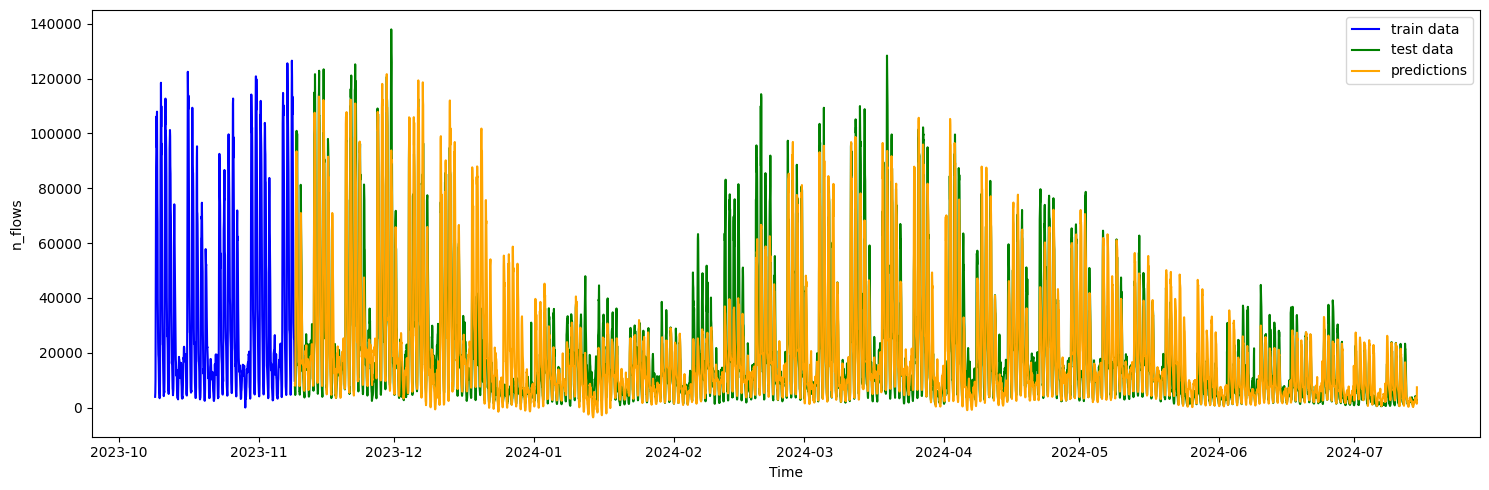

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train_df.time, train_df[TS_FEAT], color='blue', label='train data')
ax.plot(test_df.time, test_df[TS_FEAT], color='green', label='test data')
ax.plot(test_df.time, prediction[:len(test_df.time)], color='orange', label='predictions')
plt.legend()
plt.xlabel("Time")
plt.ylabel(TS_FEAT)
plt.tight_layout()
plt.show()

#### Evaluation metrics

In [49]:
from sklearn.metrics import r2_score, root_mean_squared_error

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

results_rmse = root_mean_squared_error(test_df[TS_FEAT], prediction[:len(test_df[TS_FEAT])])
results_r2_score = r2_score(test_df[TS_FEAT], prediction[:len(test_df[TS_FEAT])])
results_smape = smape(test_df[TS_FEAT], prediction[:len(test_df[TS_FEAT])])

print(f"    RMSE: {results_rmse}")
print(f"   SMAPE: {results_smape}")
print(f"R2 Score: {results_r2_score}")

    RMSE: 10939.278415348492
   SMAPE: 39.78214593698181
R2 Score: 0.7721795693310641


#### Let's save the plot data to logs

In [53]:
prediction_df = pd.DataFrame(prediction[:len(test_df.time)], index=test_df.index, columns=[TS_FEAT])

train_data = pd.concat([train_df.time, train_df[TS_FEAT]], axis=1)
train_data.to_csv('./logs/train_data_r', sep='\t')

test_data = pd.concat([test_df.time, test_df[TS_FEAT]], axis=1)
test_data.to_csv('./logs/test_data_r', sep='\t')

pred_data = pd.concat([test_df.time, prediction_df], axis=1)
pred_data.to_csv('./logs/pred_data_r', sep='\t')

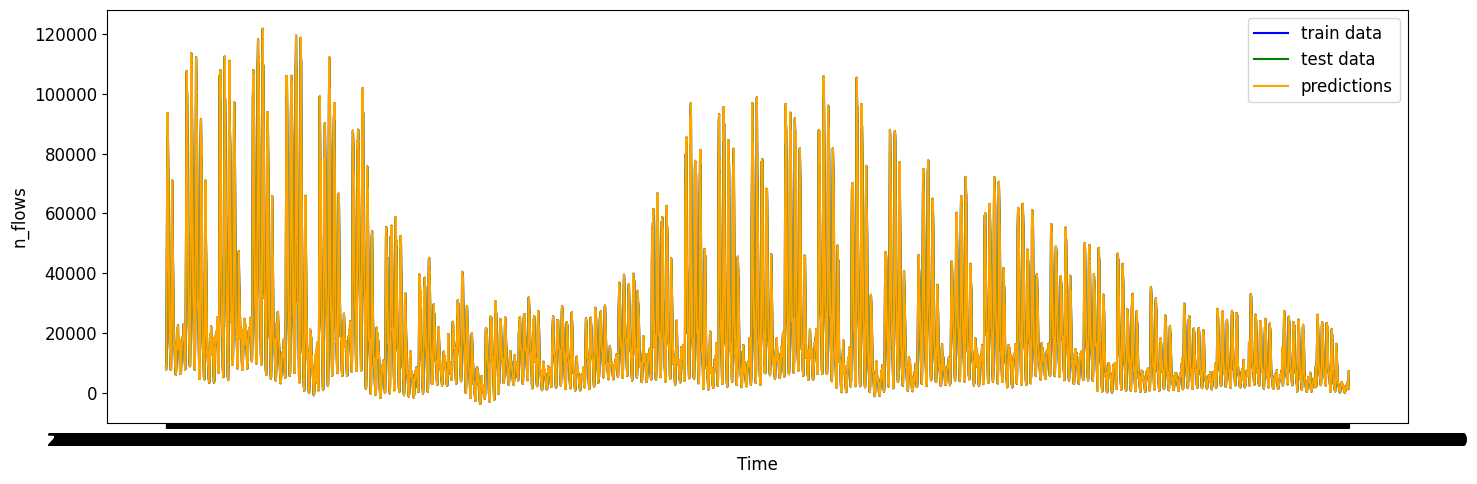

In [291]:
recover_plot_from_file('./logs/pred_data_r')

# LSTM

## Functions

In [40]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=2, num_layers=1):
        super().__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [41]:
class LSTM_TRAINING:
    def __init__(self, train_period, df=df, feature_name=TS_FEAT):
        self.train_period = train_period
        self.test_period = None
        
        self.df = df
        self.feature_name = feature_name

        self.train_df = self.df[self.df.id_time < self.train_period]
        self.train_data = self.train_df[self.feature_name].to_numpy()
        self.test_df = None
        self.test_data = None

        self.scaler = MinMaxScaler()
        self.w_size = None

        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None

        self.model = None
        self.train_time = None

        self.pred_df = None
        self.pred_data = None

        self.results_rmse = None
        self.results_r2_score = None
        self.results_smape = None

        self.pp = None

    def data_preprocess(self, flag='train'):
        if flag == 'train':
            train_data = self.scaler.fit_transform(self.train_data.reshape(-1, 1))
            x_train, y_train = sliding_windows(train_data, self.w_size)
            self.x_train, self.y_train = Variable(torch.Tensor(x_train)), Variable(torch.Tensor(y_train))

        if flag == 'test':
            test_data = self.scaler.transform(self.test_data.reshape(-1, 1))
            x_test, y_test = sliding_windows(test_data, self.w_size)
            self.x_test, self.y_test = Variable(torch.Tensor(x_test)), Variable(torch.Tensor(y_test))

    def train(self, w_size, num_epochs, learning_rate, input_size, hidden_size, num_layers, plot=False):
        self.w_size = w_size
        self.data_preprocess('train')
        self.model = LSTM(input_size, hidden_size, num_layers)
        
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        start_time = time.time()
        self.model.train()
        if plot:
            self.pp = ProgressPlotter(groups=['loss'])
        for epoch in range(num_epochs):
            outputs = self.model(self.x_train)
            optimizer.zero_grad()
            
            loss = criterion(outputs, self.y_train)
            loss.backward()
            optimizer.step()

            if plot:
                self.pp.add_scalar('loss', loss.item() / outputs.shape[0], 'train')
                self.pp.display()
        final_time = time.time()
        self.train_time = datetime.timedelta(seconds=np.ceil(final_time - start_time)).total_seconds()     

    def predict(self, test_period, flag='n+1'):
        self.test_period = test_period
        self.test_df = self.df.loc[(self.df.id_time >= self.train_period) & (self.df.id_time < self.train_period + self.test_period)]
        self.test_data = self.test_df[self.feature_name].to_numpy()
        self.data_preprocess('test')
        
        self.model.eval()
        with torch.no_grad():
            if flag == 'n+1':
                pred = self.model(torch.cat((self.x_train[len(self.x_train) - self.w_size: ], self.x_test)))
            
            elif flag == 'rolling':
                x = self.x_train[-1]
                pred = []
                for i in range(self.test_period):
                    out = self.model(x.unsqueeze(0))
                    pred.append(out.item())
                    x = torch.cat([x[1:], out])
        self.pred_data = self.scaler.inverse_transform(np.array(pred).reshape(-1, 1))
        pred_df = pd.DataFrame(self.pred_data, index=self.test_df.index, columns=[self.feature_name])
        pred_df.time = self.test_df.time
        self.pred_df = pred_df
    
    def plot_prediction(self):
        plot_forecast(self.train_df, self.test_df, self.pred_df)

    def scores(self):
        self.results_rmse, self.results_smape, self.results_r2_score = calc_metrics(self.test_df, self.pred_data.flatten())

    def save_plot_logs(self, file_path):
        save_logs(file_path, self.train_df, self.test_df, self.pred_df,)

## N + 1 forecasting

### 7 days

In [42]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 168

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in range(10):
    model = LSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, num_layers) #, plot=True)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

In [43]:
# lstm_plot = model.pp.history_dict

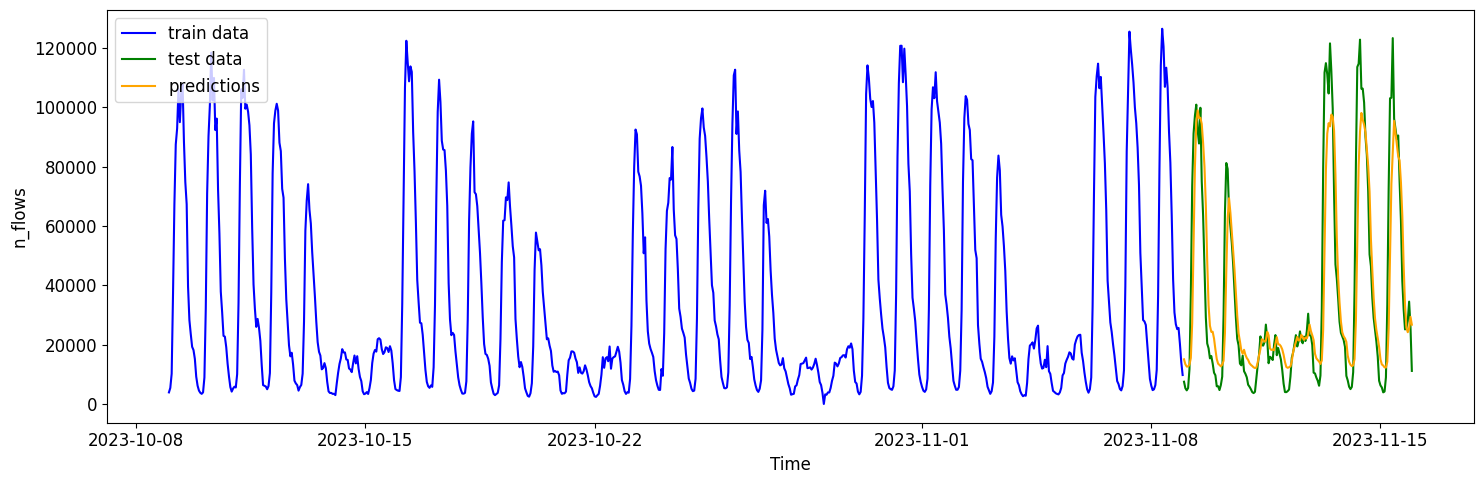

In [44]:
model.plot_prediction()

In [45]:
metrics = pd.DataFrame(columns=['train / test size', 'Training time', 'RMSE', 'SMAPE', 'R2'])
metrics.style.set_caption("LSTM N+1 prediction")

In [46]:
metrics.loc[0] = ["744 h (31 d) / 168 h (7 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time          RMSE          SMAPE  \
0  744 h (31 d) / 168 h (7 d)       0:00:01  15063 ± 3644  37.40 ± 10.28   

                R2  
0  0.8032 ± 0.0930

### 14 days

In [47]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 336

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in range(10):
    model = LSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, num_layers) #, plot=True)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

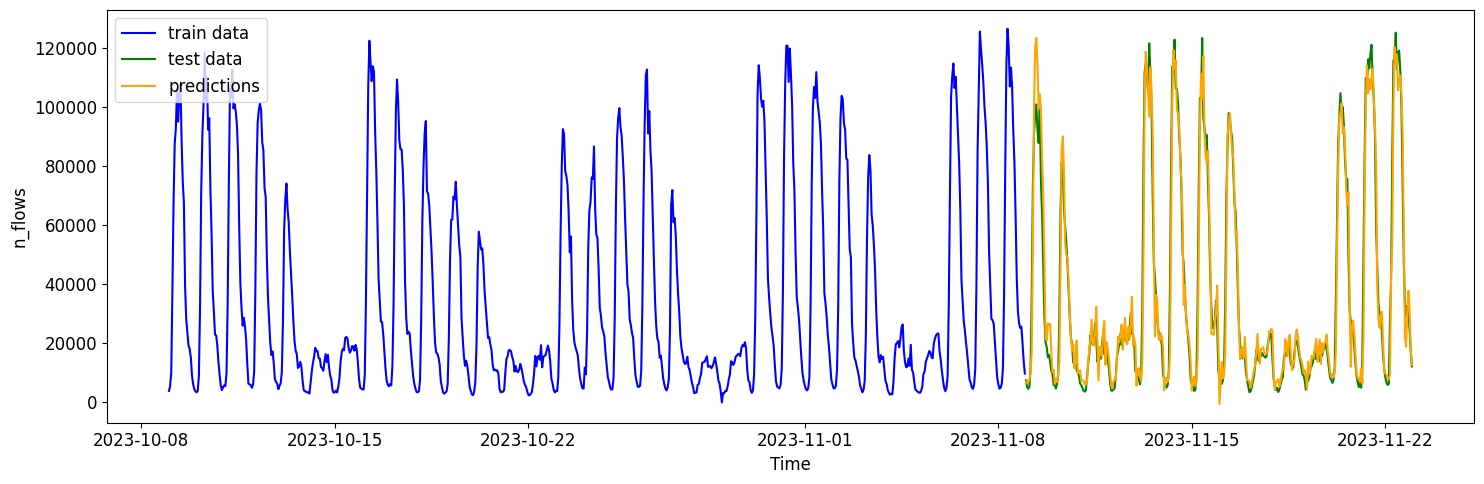

In [48]:
model.plot_prediction()

In [49]:
metrics.loc[1] = ["744 h (31 d) / 336 h (14 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time          RMSE          SMAPE  \
0   744 h (31 d) / 168 h (7 d)       0:00:01  15063 ± 3644  37.40 ± 10.28   
1  744 h (31 d) / 336 h (14 d)       0:00:01  11306 ± 2976   29.09 ± 8.06   

                R2  
0  0.8032 ± 0.0930  
1  0.8914 ± 0.0589

### 21 days

In [50]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 504

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in range(10):
    model = LSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, num_layers) #, plot=True)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

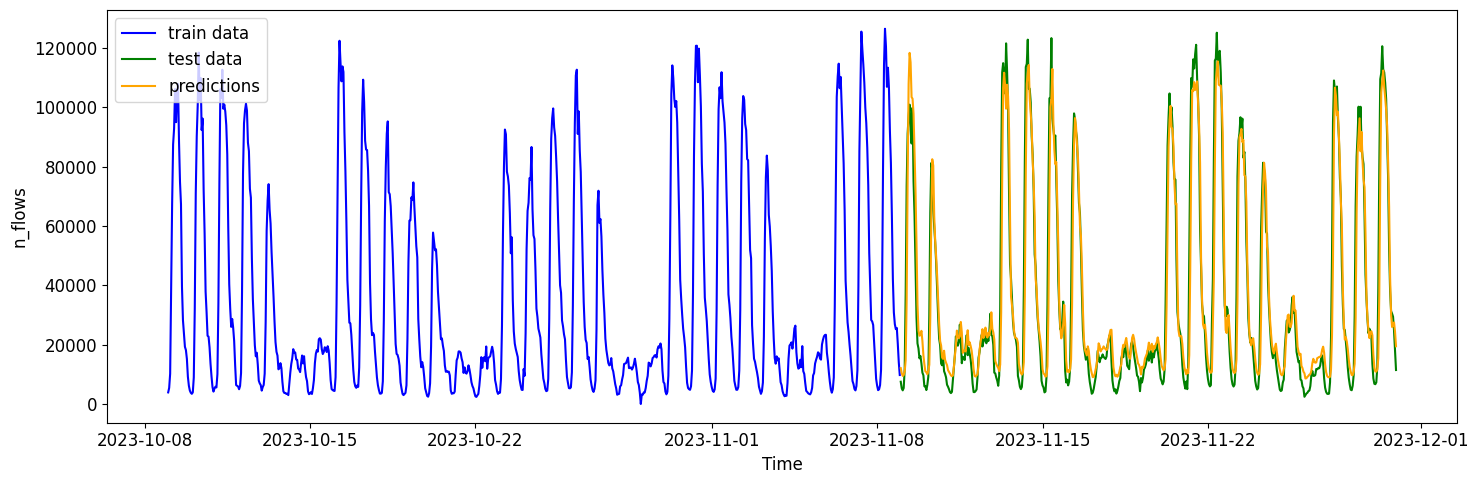

In [51]:
model.plot_prediction()

In [52]:
metrics.loc[2] = ["744 h (31 d) / 504 h (21 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time          RMSE          SMAPE  \
0   744 h (31 d) / 168 h (7 d)       0:00:01  15063 ± 3644  37.40 ± 10.28   
1  744 h (31 d) / 336 h (14 d)       0:00:01  11306 ± 2976   29.09 ± 8.06   
2  744 h (31 d) / 504 h (21 d)       0:00:01  10409 ± 2123   27.80 ± 5.67   

                R2  
0  0.8032 ± 0.0930  
1  0.8914 ± 0.0589  
2  0.9081 ± 0.0367

### 60 days

In [53]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 1140

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in range(10):
    model = LSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, num_layers) #, plot=True)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

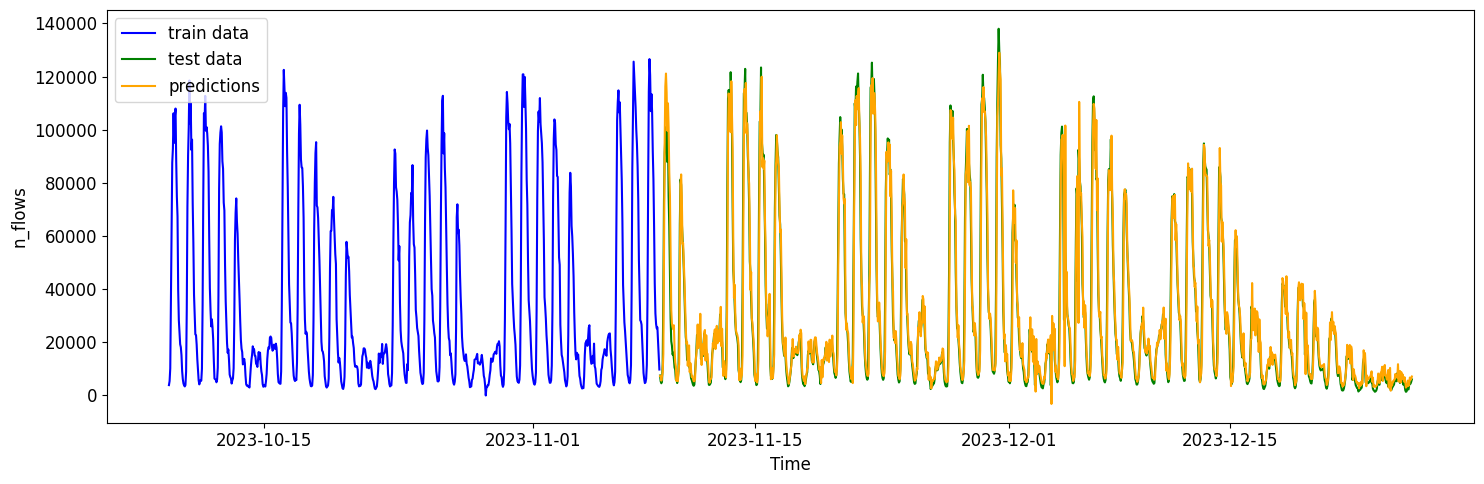

In [54]:
model.plot_prediction()

In [55]:
metrics.loc[3] = ["744 h (31 d) / 1440 h (60 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time          RMSE          SMAPE  \
0    744 h (31 d) / 168 h (7 d)       0:00:01  15063 ± 3644  37.40 ± 10.28   
1   744 h (31 d) / 336 h (14 d)       0:00:01  11306 ± 2976   29.09 ± 8.06   
2   744 h (31 d) / 504 h (21 d)       0:00:01  10409 ± 2123   27.80 ± 5.67   
3  744 h (31 d) / 1440 h (60 d)       0:00:01   9743 ± 2759  33.12 ± 10.21   

                R2  
0  0.8032 ± 0.0930  
1  0.8914 ± 0.0589  
2  0.9081 ± 0.0367  
3  0.8926 ± 0.0682

## Rolling forecasting

In [131]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 168

# w_size = 24
# w_size = TRAINING_PERIOD

num_epochs = 1000
learning_rate = 0.005

input_size = 1
# hidden_size = 64
num_layers = 1

# w = [24, 48, 72, 168]
# h = [2, 4, 8, 16, 32, 64]

# r2_max = -np.inf
# i_max = None
# j_max = None

t_all, rmse_all, smape_all, r2_all = [], [], [], []
# for i in range(len(w)): # 10
#     for j in range(len(h)):
# w_size = w[i]
# hidden_size = h[j]

w_size = 84
hidden_size = 16

model = LSTM_TRAINING(TRAINING_PERIOD, TESTING_PERIOD)
model.data_preprocess(w_size)

model.train(num_epochs, learning_rate, input_size, hidden_size, num_layers)
model.predict(flag='rolling')
# print(model.x_train, '\n')
# print(model.y_train, '\n')
# print(model.pred_data, '\n')

model.scores()
t_all.append(model.train_time)
rmse_all.append(model.results_rmse)
smape_all.append(model.results_smape)
r2_all.append(model.results_r2_score)

# if np.mean(r2_all) > r2_max:
#     r2_max = np.mean(r2_all)
#     i_max = i
#     j_max = j

# print(w[i_max], h[j_max])

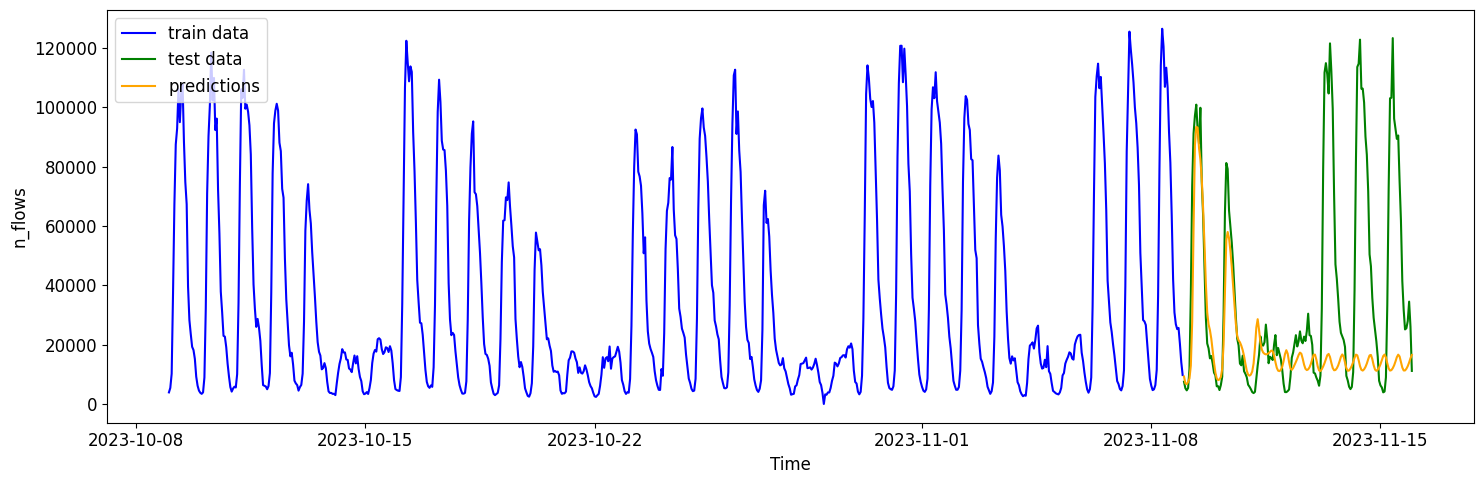

In [132]:
model.plot_prediction()

In [133]:
metrics = pd.DataFrame(columns=['train / test size', 'Training time', 'RMSE', 'SMAPE', 'R2'])
metrics.style.set_caption("LSTM rolling prediction")

In [134]:
metrics.loc[0] = ["744 h (31 d) / 168 h (7 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time       RMSE         SMAPE  \
0  744 h (31 d) / 168 h (7 d)       0:00:15  37227 ± 0  65.52 ± 0.00   

                 R2  
0  -0.1353 ± 0.0000

# QLSTM

## Functions

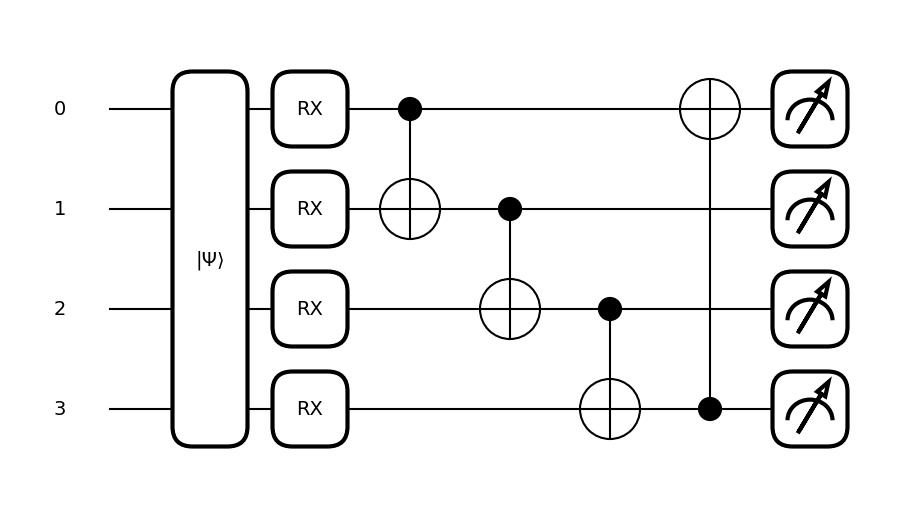

In [65]:
def circuit(inputs, weights):
    N = 4
    # qml.templates.AngleEmbedding(inputs, wires=range(N))
    qml.templates.AmplitudeEmbedding(inputs, normalize=True, wires=range(N))
    qml.templates.BasicEntanglerLayers(weights, wires=range(N))
    return [qml.expval(qml.PauliZ(wires=w)) for w in range(N)]


num_qubits = 4
weights = (torch.randn(num_qubits),)
features = torch.randn(num_qubits ** 2)

# fig, ax = qml.draw_mpl(circuit + circuit)(features, weights)
fig, ax = qml.draw_mpl(decompose(circuit, gate_set=['RX', 'RY', 'RZ', 'AmplitudeEmbedding', 'CX']))(features, weights)
plt.show()

In [76]:
class HybridModel(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend 

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            # qml.templates.AngleEmbedding(inputs, wires=self.wires_forget) 
            qml.templates.AmplitudeEmbedding(inputs, normalize=True, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            # qml.templates.AngleEmbedding(inputs, wires=self.wires_input) 
            qml.templates.AmplitudeEmbedding(inputs, normalize=True, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            # qml.templates.AngleEmbedding(inputs, wires=self.wires_update) 
            qml.templates.AmplitudeEmbedding(inputs, normalize=True, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            # qml.templates.AngleEmbedding(inputs, wires=self.wires_output) 
            qml.templates.AmplitudeEmbedding(inputs, normalize=True, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        # print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits ** 2)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_states=None):
        batch_size, seq_length, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  
            c_t = torch.zeros(batch_size, self.hidden_size)
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]
            
            v_t = torch.cat((h_t, x_t), dim=1)
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t)))

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [77]:
class QLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1

        self.qlstm = HybridModel(input_size, hidden_size, n_qubits, n_qlayers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.qlstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [78]:
class QLSTM_TRAINING(LSTM_TRAINING):
    def __init__(self, train_period):
        super().__init__(train_period)
    
    def train(self, w_size, num_epochs, learning_rate, input_size, hidden_size, n_qubits, n_qlayers, plot=False):
        self.w_size = w_size
        self.data_preprocess('train')
        self.model = QLSTM(input_size, hidden_size, n_qubits, n_qlayers)
        
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        start_time = time.time()
        self.model.train()

        if plot:
            self.pp = ProgressPlotter(groups=['loss'])
        for epoch in range(num_epochs):
            outputs = self.model(self.x_train)
            optimizer.zero_grad()
            
            loss = criterion(outputs, self.y_train)
            loss.backward()
            optimizer.step()
            
            if plot:
                self.pp.add_scalar('loss', loss.item() / outputs.shape[0], 'train')
                self.pp.display()
        final_time = time.time()
        self.train_time = datetime.timedelta(seconds=np.ceil(final_time - start_time)).total_seconds()   

## N + 1

### 7 days

In [83]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 168

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
n_qubits = 4
n_qlayers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in tqdm(range(10)):
    model = QLSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, n_qubits, n_qlayers)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:03<00:00, 180.33s/it]


In [ ]:
# qlstm_plot = model.pp.history_dict

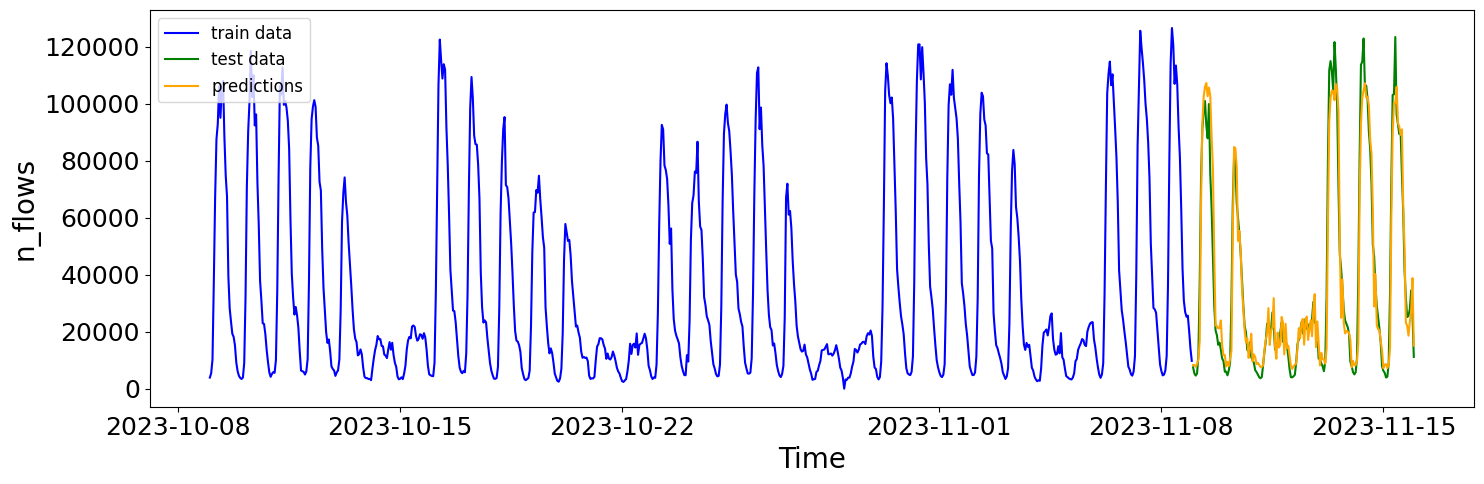

In [84]:
model.plot_prediction()

In [85]:
metrics = pd.DataFrame(columns=['train / test size', 'Training time', 'RMSE', 'SMAPE', 'R2'])
metrics.style.set_caption("LSTM N+1 prediction")

In [86]:
metrics.loc[0] = ["744 h (31 d) / 168 h (7 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time        RMSE         SMAPE  \
0  744 h (31 d) / 168 h (7 d)       0:03:00  8230 ± 634  21.65 ± 2.37   

                R2  
0  0.9442 ± 0.0089

### 14 days

In [87]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 336

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
n_qubits = 4
n_qlayers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in tqdm(range(10)):
    model = QLSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, n_qubits, n_qlayers)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [29:46<00:00, 178.68s/it]


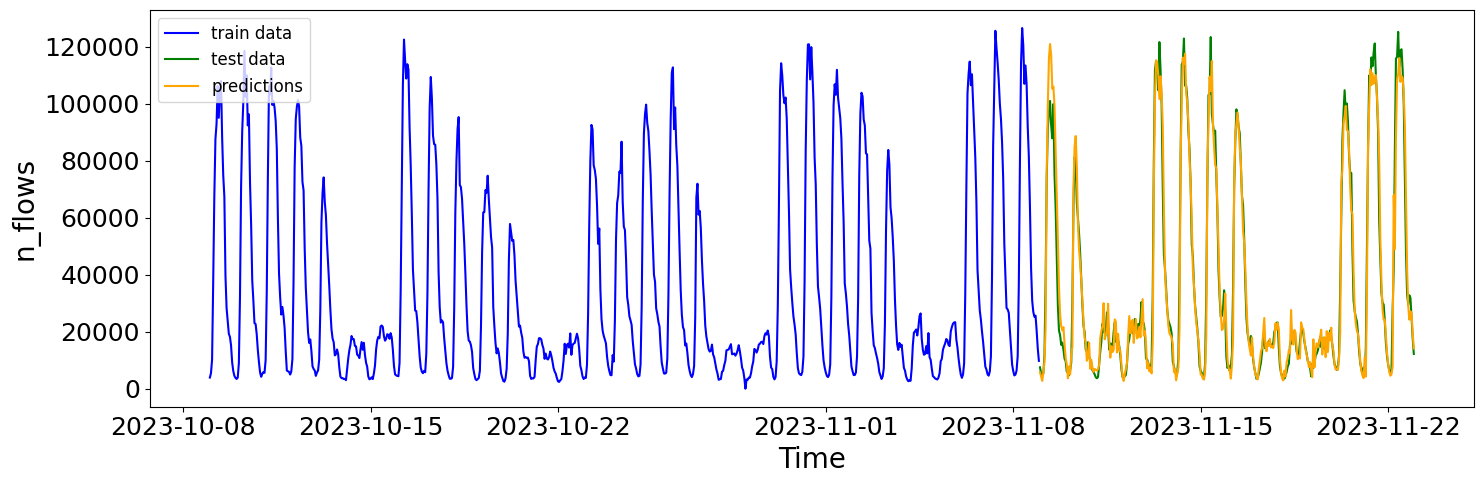

In [88]:
model.plot_prediction()

In [89]:
metrics.loc[1] = ["744 h (31 d) / 336 h (14 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time        RMSE         SMAPE  \
0  744 h (31 d) / 336 h (14 d)       0:02:59  8092 ± 856  20.89 ± 1.80   

                R2  
0  0.9474 ± 0.0114

## 21 days

In [90]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 504

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
n_qubits = 4
n_qlayers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in tqdm(range(10)):
    model = QLSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, n_qubits, n_qlayers)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:08<00:00, 180.81s/it]


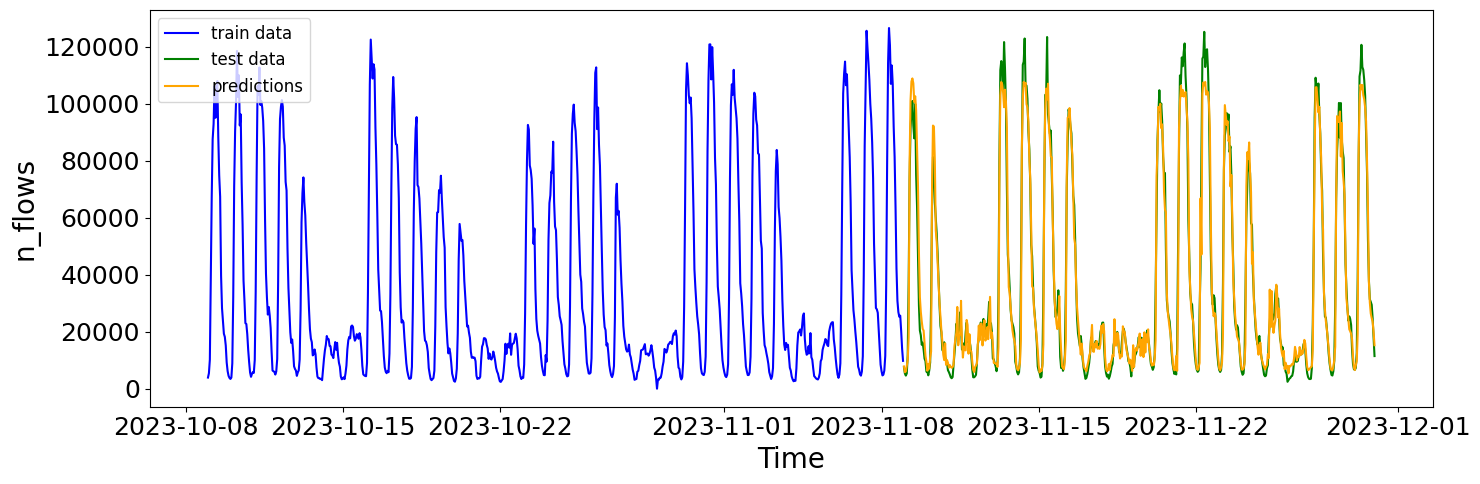

In [91]:
model.plot_prediction()

In [92]:
metrics.loc[2] = ["744 h (31 d) / 504 h (21 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

train / test size Training time        RMSE         SMAPE  \
0  744 h (31 d) / 504 h (21 d)       0:03:01  7366 ± 851  19.69 ± 2.00   

                R2  
0  0.9552 ± 0.0108

## 60 days

In [93]:
TRAINING_PERIOD = 744
TESTING_PERIOD = 1440

w_size = 24

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
n_qubits = 4
n_qlayers = 1

t_all, rmse_all, smape_all, r2_all = [], [], [], []
for i in tqdm(range(10)):
    model = QLSTM_TRAINING(TRAINING_PERIOD)
    
    model.train(w_size, num_epochs, learning_rate, input_size, hidden_size, n_qubits, n_qlayers)
    model.predict(TESTING_PERIOD)

    model.scores()
    t_all.append(model.train_time)
    rmse_all.append(model.results_rmse)
    smape_all.append(model.results_smape)
    r2_all.append(model.results_r2_score)

  0%|                                                                                           | 0/10 [02:32<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model.plot_prediction()

In [ ]:
metrics.loc[0] = ["744 h (31 d) / 1440 h (60 d)", 
                  f'{datetime.timedelta(seconds=np.round(np.mean(t_all)))}', 
                  f'{np.mean(rmse_all):.0f} ± {np.std(rmse_all):.0f}',
                  f'{np.mean(smape_all):.2f} ± {np.std(smape_all):.2f}',
                  f'{np.mean(r2_all):.4f} ± {np.std(r2_all):.4f}']
metrics

# Plot results

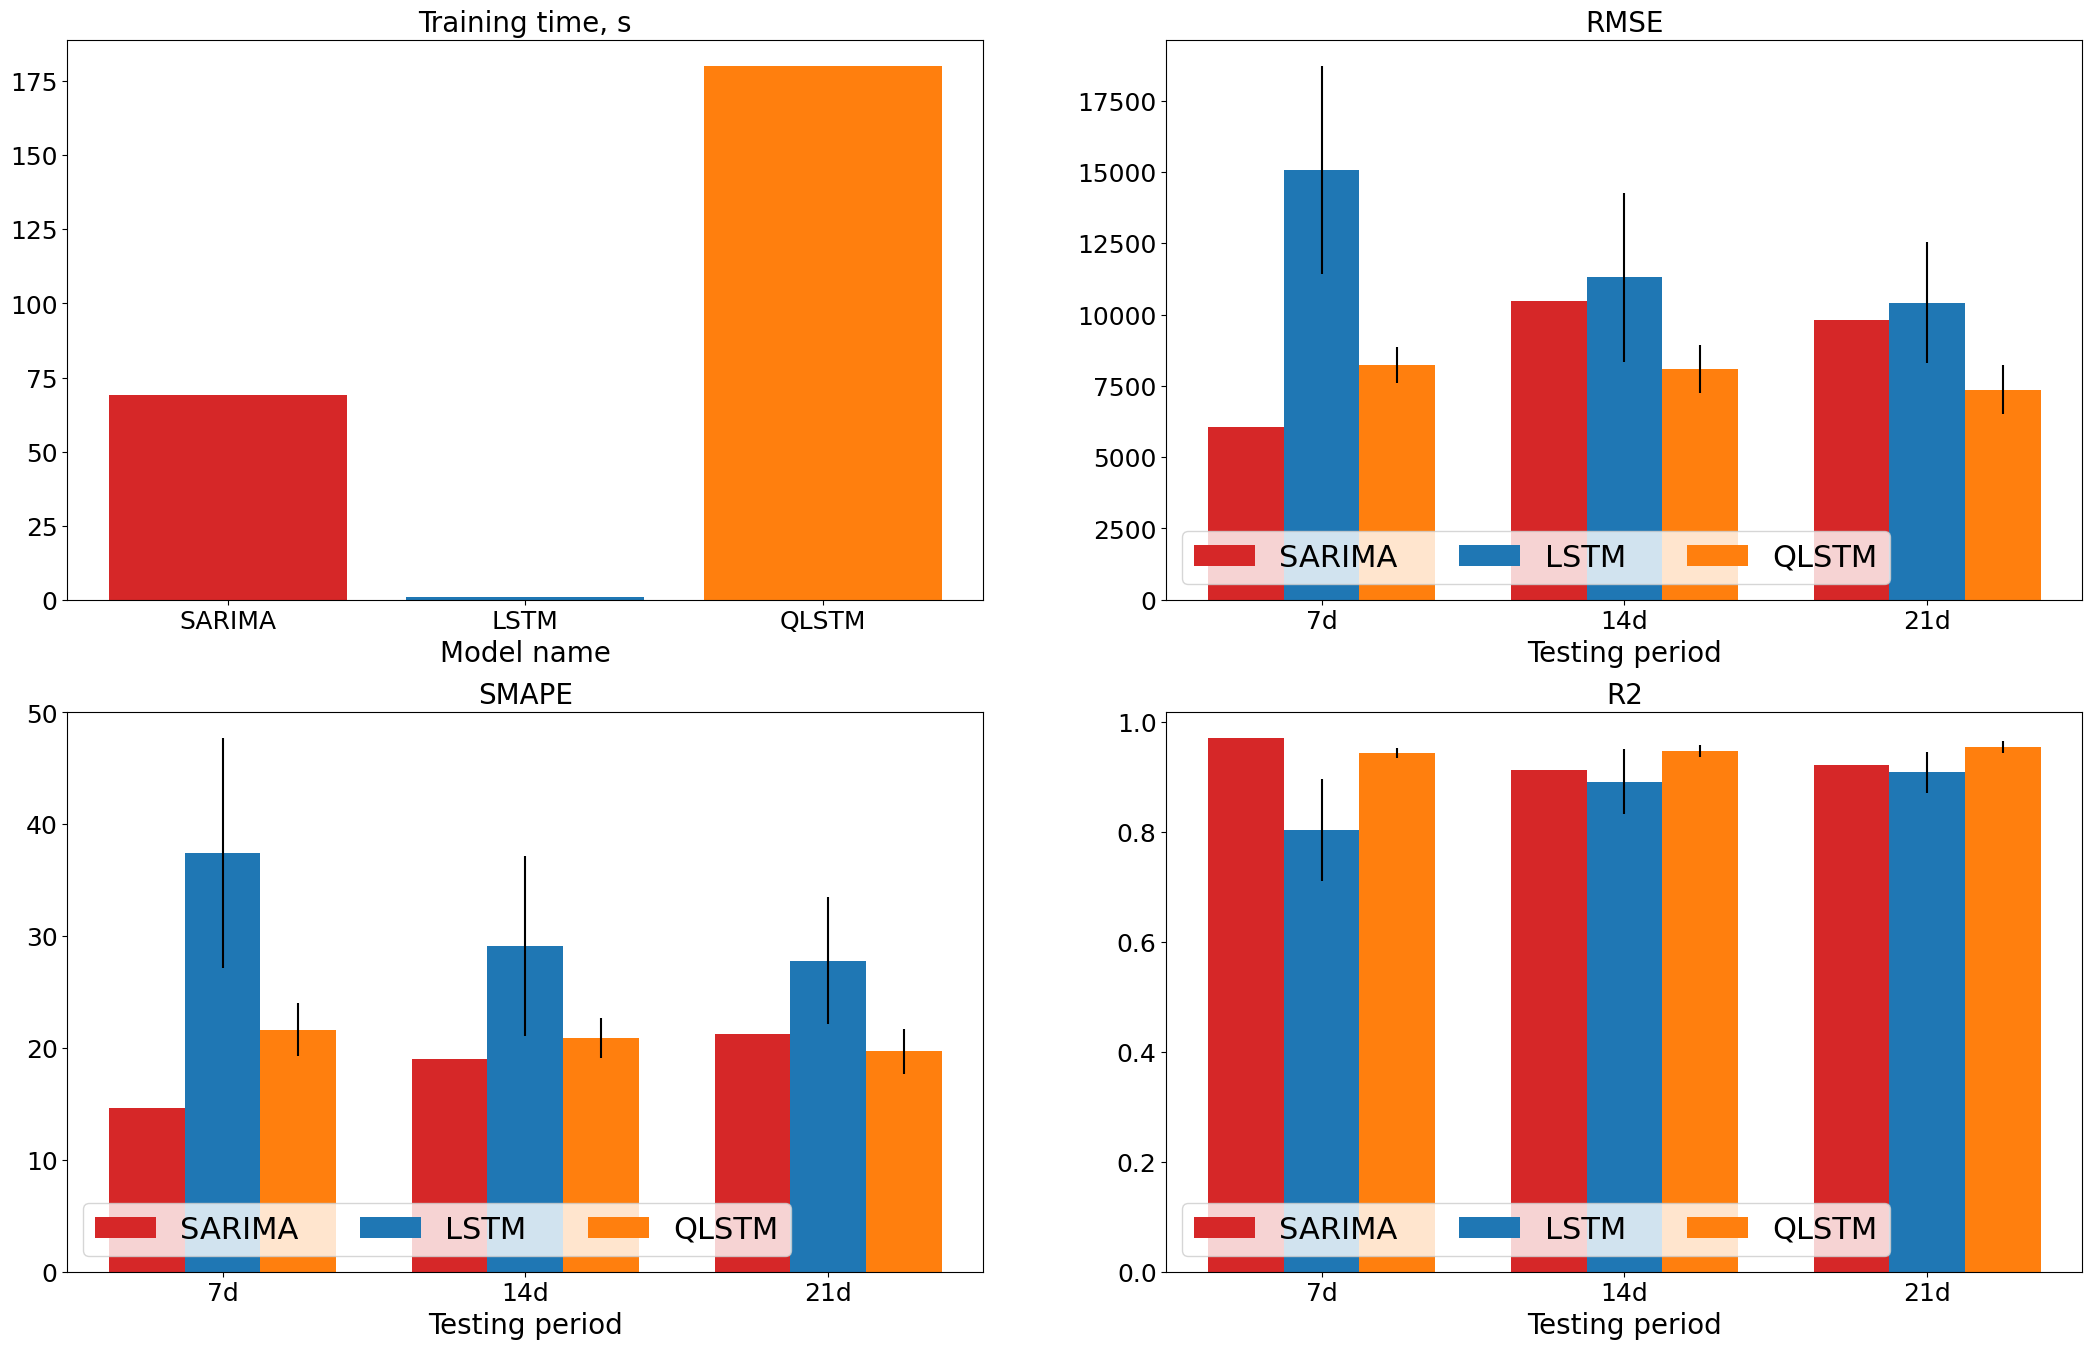

In [94]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=((26, 16)))
plt.rc('font', size=22) 
plt.rc('axes', titlesize=20)     
plt.rc('axes', labelsize=20)    
plt.rc('xtick', labelsize=18)    
plt.rc('ytick', labelsize=18)

models = ['SARIMA', 'LSTM', 'QLSTM']
test_period = ['7d', '14d', '21d'] #, '60d']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']
width = 0.25 
ind = np.arange(len(test_period)) 

ax[0,0].set_title('Training time, s')
ax[0,0].bar(models, [69, 1, 180], color=bar_colors)
ax[0,0].set_xlabel('Model name')

ax[0,1].set_title('RMSE')
ax[0,1].bar(ind, [6043, 10462, 9810], label=models[0], width=width, color=bar_colors[0])
ax[0,1].bar(ind + width, [15063, 11306, 10409], yerr=[3644, 2976, 2123], label=models[1], width=width, color=bar_colors[1])
ax[0,1].bar(ind + 2 * width, [8230, 8092, 7366], yerr=[634, 856, 851], label=models[2], width=width, color=bar_colors[2])
ax[0,1].legend(loc=3, ncols=3)
ax[0,1].set_xlabel('Testing period')
ax[0,1].set_xticks(ind + width, labels=test_period)

ax[1,0].set_title('SMAPE')
ax[1,0].bar(ind, [14.67, 19.05, 21.21], label=models[0], width=width, color=bar_colors[0])
ax[1,0].bar(ind + width, [37.40, 29.09, 27.80], yerr=[10.28, 8.06, 5.67], label=models[1], width=width, color=bar_colors[1])
ax[1,0].bar(ind + 2 * width, [21.65, 20.89, 19.69], yerr=[2.37, 1.80, 2.00], label=models[2], width=width, color=bar_colors[2])
ax[1,0].legend(loc=3, ncols=3)
ax[1,0].set_xlabel('Testing period')
ax[1,0].set_xticks(ind + width, labels=test_period)

ax[1,1].set_title('R2')
ax[1,1].bar(ind, [0.9701, 0.9131, 0.9217], label=models[0], width=width, color=bar_colors[0])
ax[1,1].bar(ind + width, [0.8032, 0.8914, 0.9081], yerr=[0.0930, 0.0589, 0.0367], label=models[1], width=width, color=bar_colors[1])
ax[1,1].bar(ind + 2 * width, [0.9442, 0.9474, 0.9552], yerr=[0.0089, 0.0114, 0.0108], label=models[2], width=width, color=bar_colors[2])
ax[1,1].legend(loc=3, ncols=3)
ax[1,1].set_xlabel('Testing period')
ax[1,1].set_xticks(ind + width, labels=test_period)

plt.show()

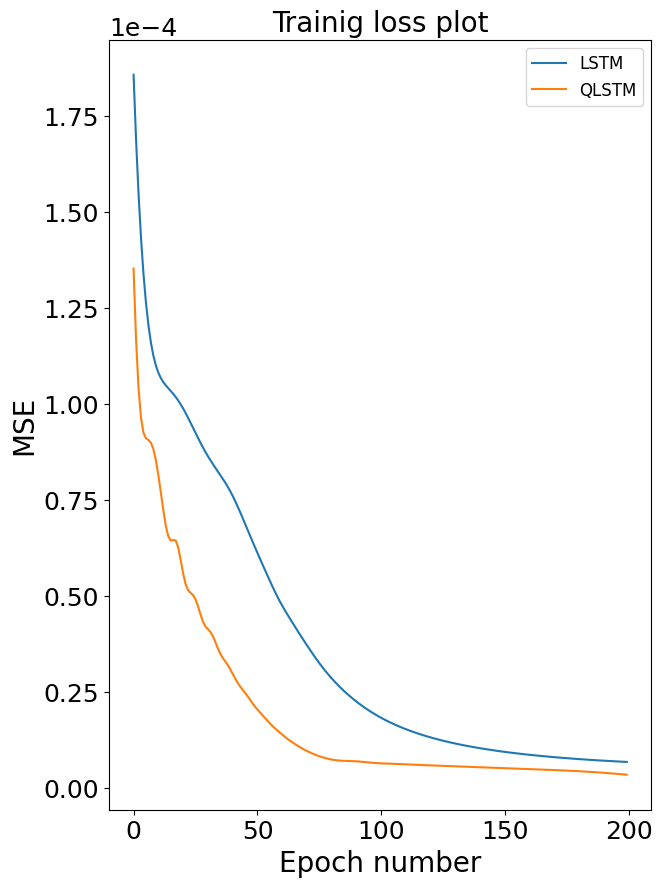

In [324]:
fig, ax = plt.subplots(figsize=((7, 10)))
plt.plot(range(len(lstm_plot['loss']['train'])), lstm_plot['loss']['train'], label='LSTM')
plt.plot(range(len(qlstm_plot['loss']['train'])), qlstm_plot['loss']['train'], label='QLSTM')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0.0002))
plt.title('Trainig loss plot')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.legend()
plt.show()